# Import libraries

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#Author: Sanjay Kottapalli, Dana Pe'er lab (kottapas@mskcc.org)

import numpy as np
import numpy.matlib
import pandas as pd
import scanpy as sc
from scanpy.external.pp import magic
import scipy
from sklearn.metrics import adjusted_rand_score
from scipy.stats.mstats import zscore
from scipy.stats import pearsonr
import csv
import os
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from copy import deepcopy
import timeit
from joblib import Parallel, delayed
from collections import Counter
np.random.seed(0)

# Define functions

In [ ]:
def import_seqc_data(sample_name, path, dense=True):
    print('\nsample: ' + sample_name)
    if dense:
        PATH_TO_COUNT_CSV = path + sample_name + '_dense.csv'
        # import csv
        raw_counts = pd.read_csv(PATH_TO_COUNT_CSV, index_col=0, header=0)
        print(raw_counts.shape)
        #
        with open(PATH_TO_COUNT_CSV, "r") as f:
            reader = csv.reader(f)
            original_column_names = next(reader)
        # remove the first entry of this list, it belongs to the index column
        gene_names = original_column_names[1:]
        # and label the index column with name 'cell_barcodes'
        raw_counts.index.name = 'cell_barcodes'
        # convert indices to strings instead of integers for compatibility with scanpy
        raw_counts.index = raw_counts.index.astype(str)
        # python automatically converts duplicate column names to numbered column names,
        # e.g. 'X', 'X.1', 'X.2' etc. We can import the original column names from our CSV file:

        # now transpose the dataframe (for compatibility with panda's groupby function), 
        # then group by gene names, and add up the counts for genes with the same name
        raw_counts_transposed = raw_counts.T
        raw_counts_transposed_clean = raw_counts_transposed.groupby(gene_names, axis='index', sort=False).agg('sum')
        # transpose back
        raw_counts_clean = raw_counts_transposed_clean.T
        # if columns were added up, print how many:
        number_of_columns_removed = raw_counts.shape[1] - raw_counts_clean.shape[1]
        if number_of_columns_removed > 0:
            print(str(number_of_columns_removed) + ' columns were each merged with another column that had the same gene name.')
        # remove CLUSTER column:
        if 'CLUSTER' in raw_counts_clean.columns:
            raw_counts_clean.drop(columns='CLUSTER', inplace=True)
        # convert index type to string for compatibility with scanpy
        raw_counts_clean.index = raw_counts_clean.index.astype('str')
        adata = sc.AnnData(X = raw_counts_clean)
    else:
        barcodes = pd.read_csv(path+sample_name+'_sparse_counts_barcodes.csv', index_col=0, header=None)
        barcodes = barcodes[1].values
        barcodes = [str(i) for i in barcodes]
        gene_names = pd.read_csv(path+sample_name+'_sparse_counts_genes.csv', index_col=0, header=None)
        gene_names = gene_names[1].values
        sparse_counts = scipy.io.mmread(path+sample_name+'_sparse_molecule_counts.mtx').tocsc()
        #print("# of bytes: "+str(sparse_counts.data.nbytes))
        print(sparse_counts.shape)
        #sparse_counts = sparse_counts.toarray()#np.array(sparse_counts)
        #print(sparse_counts.shape)
        #raw_counts = pd.DataFrame.sparse.from_spmatrix(data=sparse_counts, index=barcodes, columns=gene_names)
        
        gene_dup = pd.Series(dict(Counter(gene_names)))
        gene_dup = gene_dup[gene_dup>1]
        #print(gene_dup)
        #print(len(set(gene_names)))
        gene_dup = list(gene_dup.keys())
        number_of_columns_removed = len(gene_dup)
        
        # sum of duplicate columns for each duplicate gene
        sum_dict = {i:sparse_counts[:,np.where(gene_names==i)[0]].sum(axis=1) for i in gene_dup}
        dup_index = []
        for i in gene_dup:
            dup_index += list(np.where(gene_names==i)[0])
        #print(sum_dict)
        #print(len(dup_index))
        #for i in sum_dict:
        #    print(sum_dict[i].sum(axis=0))
        
        #print(len(gene_names), sparse_counts.shape)
        keep_index = list(set(range(len(gene_names))) - set(dup_index))
        new_genes = list(gene_names[keep_index])
        new_counts = sparse_counts[:, keep_index]
        #print(len(new_genes), new_counts.shape)
        #print(new_counts.shape, type(new_counts))
        for i in sum_dict.keys():
            #print(sum_dict[i])
            #print(type(new_counts), type(sum_dict[i]))
            new_counts = scipy.sparse.hstack([new_counts, sum_dict[i]])
            new_genes.append(i)
        #print(len(new_genes), new_counts.shape)
        new_counts = new_counts.tocsc()
        print(new_counts.shape)#, type(new_counts))
        
        adata = sc.AnnData(X = new_counts, obs=pd.DataFrame(index=barcodes), var=pd.DataFrame(index=new_genes))
        
        if number_of_columns_removed > 0:
            print(str(number_of_columns_removed) + ' columns were each merged with another column that had the same gene name.')
       # take the min libsize in the dense cells, and 
        
        adata, mito_genes, RB_genes_in_data = qc_metrics(adata)
        # remove high mito frac cells
        cutoff = 20.0
        mito_val = adata.obs['pct_counts_mito']
        #print(mito_val)
        via_cells = mito_val[mito_val<cutoff]
        #print(via_cells)
        adata = adata[via_cells.index, :]
        print(adata.shape)
        
        PATH_TO_COUNT_CSV = path + sample_name + '_dense.csv'
        raw_counts = pd.read_csv(PATH_TO_COUNT_CSV, index_col=0, header=0)
        seqc_cells = [str(i) for i in raw_counts.index]
        libsize = adata.obs['original_total_counts'].sort_values(ascending=False)
        #pd.Series(index=adata.obs.index, data=np.array(np.sum(adata.X, axis=1).flatten())[0], dtype=str).sort_values(ascending=False)
        
        #difference = set(seqc_cells)-set([str(i) for i in libsize.iloc[:len(seqc_cells)+15000].index])
        #print(len(seqc_cells),len(difference))
        #print(seqc_cells[:20])
        #print(libsize.iloc[:20])
        
        adata = adata[libsize.iloc[:len(seqc_cells)+15000].index, :] # all dense cells + 15,000
        adata = sc.AnnData(X = adata.X, obs=pd.DataFrame(index=adata.obs.index), var=pd.DataFrame(index=adata.var.index))
        print(adata.shape)
        print("Cells filtered.")
    
    return adata

In [ ]:
def qc_metrics(adata, path_RB=''):
    mito_genes = adata.var_names.str.startswith('MT-')
    adata.var['mito'] = mito_genes
    mito_genes = np.array(adata.var.index)[mito_genes]
    
    path_RB = path_RB+'RB_genes_human'
    with open(path_RB,'r') as file:
        lines = file.readlines()
    RB_genes = [x.rstrip('\n') for x in lines]
    data_genes = list(adata.var.index)
    RB_genes_in_data = set(data_genes).intersection(RB_genes)
    RB_genes_in_data = list(RB_genes_in_data)
    
    adata.var['ribo'] = False
    adata.var.loc[RB_genes_in_data, 'ribo'] = True
    
    sc.pp.calculate_qc_metrics(adata, qc_vars=('mito', 'ribo'), inplace=True)
    adata.obs['original_total_counts'] = adata.obs['total_counts']
    adata.obs['log10_original_total_counts'] = np.log10(adata.obs['original_total_counts'])
    print('QC metrics calculated.')
    
    return adata, mito_genes, RB_genes_in_data

In [ ]:
def norm_filter(adata, mito_genes, RB_genes_in_data, log=True, remove_ribo=True, remove_mito=True, highly_var=False, markers=[]):
    
    adata.layers['raw_counts'] = adata.X
    # filter genes expressed in few cells
    print(adata.shape)
    sc.pp.filter_genes(adata, min_cells = 10)
    print(adata.shape)
    
    # libsize normalize
    if type(adata.X)==np.ndarray:
        med_libsize = np.median(np.sum(adata.X, axis=1))
    else:
        sums = np.array(np.sum(adata.X, axis=1).flatten())[0]
        #med_libsize = np.median(sums)
        if min(sums) == 0:
            empty_cells = set(np.where(sums==0)[0])
            print('# of 0-count droplets: '+str(len(empty_cells)))
            all_cells = set(adata.obs.index)
            keep_cells = all_cells-empty_cells
            adata = adata[keep_cells, :]
            sums = np.array(np.sum(adata.X, axis=1).flatten())[0]
        med_libsize = np.median(sums)

        print('Median library size: ' + str(med_libsize))

    sc.pp.normalize_total(adata)

    # log transform
    if log:
        adata.X = np.log2(adata.X+0.1)

        for i in deepcopy(markers):
            try:
                adata.obs[i+'_exp'] = adata[:,i].X
            except:
                markers.remove(i)
                print(i)

    else:
        for i in deepcopy(markers):
            try:
                adata.obs[i+'_exp'] = np.log2(adata[:,i].X+0.1)
            except:
                markers.remove(i)
                print(i)

    # remove ribosomal genes
    if remove_ribo:
        RB_genes_in_data.append('MALAT1')
        adata = adata[:,[x not in RB_genes_in_data for x in adata.var.index]]
        print(adata.shape)

    # remove mitochondrial genes
    if remove_mito:
        adata = adata[:,[x not in mito_genes for x in adata.var.index]]
        print(adata.shape)

    # highly variable gene selection
    print(highly_var)
    if highly_var:
        if not log:
            print('Im here1')
            sc.pp.highly_variable_genes(adata, layer='raw_counts', flavor='seurat_v3',max_mean=np.inf, n_top_genes=2000)#, batch_key='Sample ID')
            print(sum(adata.var['highly_variable']))
            adata.var.loc[markers, 'highly_variable'] = True
            print(sum(adata.var['highly_variable']))
            print(adata.shape)
        elif log:
            print('Im here2')
            sc.pp.highly_variable_genes(adata, layer=None, flavor='cell_ranger', max_mean=np.inf, n_top_genes=2000)#, batch_key='Sample ID')
            print(sum(adata.var['highly_variable']))
            adata.var.loc[markers, 'highly_variable'] = True
            print(sum(adata.var['highly_variable']))

    return adata, markers#adata_unlog, markers

In [ ]:
def plot_pca(adata):
    #print("I am in here 1")
    
    print(adata.X)
    try:
        print(adata.shape)
        N = 1000
        adata_new = sc.tl.pca(adata, n_comps=N, copy = True)
    except:
        print(adata.shape) 
        N = min(adata.shape) - 1
        adata_new = sc.tl.pca(adata, n_comps=N, copy = True)
    
    #Plot variance explained
    x = range(len(adata_new.uns['pca']['variance_ratio']))
    y = adata_new.uns['pca']['variance_ratio']
    plt.scatter(x,y,s=4)
    plt.xlabel('PC')
    plt.ylabel('Fraction of variance explained')
    plt.title('Fraction of variance explained per PC')
    plt.show()
    
    #Plot cumulative variance
    cml_var_explained = np.cumsum(adata_new.uns['pca']['variance_ratio'])
    x = range(len(adata_new.uns['pca']['variance_ratio']))
    y = cml_var_explained
    plt.scatter(x,y,s=4)
    plt.xlabel('PC')
    plt.ylabel('Cumulative fraction of variance explained')
    plt.title('Cumulative fraction of variance explained by PCs')
    plt.show()
    
    return cml_var_explained, adata_new.uns['pca']['variance_ratio']
    
def kneepoint(vec):
    #print("I am in here 4")
    curve =  [1-x for x in vec]
    nPoints = len(curve)
    allCoord = np.vstack((range(nPoints), curve)).T
    np.array([range(nPoints), curve])
    firstPoint = allCoord[0]
    lineVec = allCoord[-1] - allCoord[0]
    lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
    vecFromFirst = allCoord - firstPoint
    scalarProduct = np.sum(vecFromFirst * numpy.matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
    vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
    vecToLine = vecFromFirst - vecFromFirstParallel
    distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
    idxOfBestPoint = np.argmax(distToLine)
    
    return idxOfBestPoint
    
def run_pca_knee(adata):
    cml, var = plot_pca(adata)

    knee = kneepoint(var)
    
    print("Knee point: "+str(knee))
    print("Explained variance: " + str(cml[knee]))

    x=list(range(len(cml)))
    plt.plot(x[:5*knee],cml[:5*knee])
    plt.show()

    adata_new = sc.tl.pca(adata, n_comps=knee+1, copy=True)
    sc.pl.pca_loadings(adata_new, components=range(1,4))
    
    return adata_new

In [ ]:
def files_MAST(adata, cell_type = '', outdir = ''):
    
    # if directory doesn't exist, create it
    if not os.path.exists('DEA/' + cell_type):
        os.makedirs('DEA/' + cell_type)
    
    adata_celltype = deepcopy(adata)
    #adata_celltype = adata_celltype[adata_celltype.obs['final_subclusters'].isin([cell_type]),:]
    print(cell_type + '\t'+"Dimensions" + "\t"+ "{}".format(adata_celltype.shape))
    
    # make a dataframe for the expression matrix
    expmat = pd.DataFrame(adata_celltype.X, columns = adata_celltype.var.index, index = adata_celltype.obs.index)

    # make a dataframe for the observation data
    cdata = pd.DataFrame(adata_celltype.obs, columns=adata_celltype.obs.columns, index = adata_celltype.obs.index)

    
    expmat.to_csv(r'DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv', index=True)
    cdata.to_csv(r'DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv', index=True)
    
    print("Files written for {}".format(cell_type))

In [ ]:
def run_MAST_for_celltype(adata, cell_type):
    start_time = timeit.default_timer()
    MAST = './runMAST.R'
    
    # run 
    files_MAST(adata = adata, cell_type = cell_type)
    
    expmat_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_exp_mat.csv')
    cdata_Inputfile = ('DEA/'+ cell_type + '/adata_'+ cell_type+ '_cdata.csv')
    output_file_cort = 'DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_cort.csv" 
    output_file_bs = 'DEA/' +  cell_type + "/MAST_DEA_" + cell_type + "_bs.csv" 
    
    print("Running " + MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " + output_file_bs)
    
    os.system(MAST + " " + expmat_Inputfile + " " + cdata_Inputfile + " " + output_file_cort + " " + output_file_bs)
    out_str = "Finished running MAST on"+ "( " + cell_type +  ")" +" in {} seconds.".format(timeit.default_timer()-start_time)
    
    return out_str

In [ ]:
godsnot_64 = [
    # "#000000",  # remove the black, as often, we have black colored annotation
    "#d9d929", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#6A3A4C", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
    "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
    "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
    "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
    "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
    "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
    "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
    "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
    "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
    "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
    "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72"]

# Populate input parameters

In [ ]:
# populate from command line
samples = ['1819_C1029_Ctrl_ES_Cort_IGO_10837_23', '1820_C1029_Ctrl_ES_BS_IGO_10856_3', '1821_996_VE_ES_Cort_IGO_10875_6', '1822_996_VE_ES_BS_IGO_10875_7']
indir = './input/'
outdir = './output_Nov/'
figures = './figures/'

In [ ]:
adata_final_high_var = sc.read_h5ad(outdir+'adata_final_high_var_final_clusters_updated.h5ad')

In [ ]:
adata_final_high_var.shape

# OPC subset

In [ ]:
adata_opc = deepcopy(adata_final_high_var)
adata_opc = adata_opc[adata_opc.obs['final_subclusters'].isin(['OPC']),:]
adata_opc.shape

In [ ]:
broad_clusters = adata_opc.obs['Condition']
unique_clusters = np.unique(broad_clusters.values)
samples = adata_opc.obs['Sample ID']
print('Cell counts in each cluster for each sample: ')

for cluster in unique_clusters:
    print('Cluster: '+str(cluster))
    index = broad_clusters[broad_clusters==cluster].index
    count = Counter(samples[index].values)
    print(count)

In [ ]:
path_to_h5ad_file = outdir+'adata.h5ad'
adata = sc.read_h5ad(path_to_h5ad_file)
print(adata)
# Add a new column describing the sample condition
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1819_C1029_Ctrl_ES_Cort_IGO_10837_23', "Control", "NA")
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1820_C1029_Ctrl_ES_BS_IGO_10856_3', "Control", adata.obs['Condition'])
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1821_996_VE_ES_Cort_IGO_10875_6', "VE", adata.obs['Condition'])
adata.obs['Condition'] = np.where(adata.obs['Sample ID'] == '1822_996_VE_ES_BS_IGO_10875_7', "VE", adata.obs['Condition'])


adata.obs.head()

In [ ]:
# Add a new column describing the sample condition
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1819_C1029_Ctrl_ES_Cort_IGO_10837_23', "Cortex", "NA")
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1820_C1029_Ctrl_ES_BS_IGO_10856_3', "BrainStem", adata.obs['B_region'])
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1821_996_VE_ES_Cort_IGO_10875_6', "Cortex", adata.obs['B_region'])
adata.obs['B_region'] = np.where(adata.obs['Sample ID'] == '1822_996_VE_ES_BS_IGO_10875_7', "BrainStem", adata.obs['B_region'])


#adata.obs
# count the number of NAs
sum(pd.isna(adata.obs['B_region']))

In [18]:
adata_opc = adata[adata_opc.obs.index, :]
adata_opc.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(496, 22292)

## QC

In [19]:
adata_opc, mito_genes, RB_genes_in_data = qc_metrics(adata_opc)
markers = []
if type(adata_opc.X)==np.ndarray:
    pass
else:
    print(type(adata_opc.X))
    #print(adata_norm.X.shape)
    adata_opc.X = adata_opc.X.toarray()
    #print(adata_norm.X.shape)
adata_opc.X = pd.DataFrame(data=adata_opc.X).fillna(0).values

Trying to set attribute `.var` of view, copying.


QC metrics calculated.
<class 'scipy.sparse.csr.csr_matrix'>


In [20]:
adata_opc.shape

(496, 22292)

## Normalization

In [21]:
markers = []
adata_opc, markers = norm_filter(adata_opc, mito_genes, RB_genes_in_data, markers=[], highly_var=True)
adata_opc.obs.head()

(496, 22292)
(496, 10664)
(496, 10508)
(496, 10496)
True
Im here2


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.uns` of view, copying.


2000
2000


,Sample ID,Condition,B_region,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_50_genes,pct_counts_in_top_100_genes,pct_counts_in_top_200_genes,pct_counts_in_top_500_genes,total_counts_mito,log1p_total_counts_mito,pct_counts_mito,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,original_total_counts,log10_original_total_counts
cell_barcodes,,,,,,,,,,,,,,,,,,,
160381150062388_1820_C1029_Ctrl_ES_BS_IGO_10856_3,1820_C1029_Ctrl_ES_BS_IGO_10856_3,Control,BrainStem,2294,7.738488,5274.0,8.570734,24.326887,32.195677,41.714069,59.177095,2.0,1.098612,0.037922,29.0,3.401197,0.549867,5274.0,3.722140
134946219223275_1821_996_VE_ES_Cort_IGO_10875_6,1821_996_VE_ES_Cort_IGO_10875_6,VE,Cortex,848,6.744059,1258.0,7.138073,25.357711,34.658188,48.489666,72.337043,1.0,0.693147,0.079491,12.0,2.564949,0.953895,1258.0,3.099681
192189945571748_1822_996_VE_ES_BS_IGO_10875_7,1822_996_VE_ES_BS_IGO_10875_7,VE,BrainStem,1609,7.383989,3004.0,8.008033,23.069241,31.757656,43.009321,63.082557,8.0,2.197225,0.266312,40.0,3.713572,1.331558,3004.0,3.477700
134517112388013_1819_C1029_Ctrl_ES_Cort_IGO_10837_23,1819_C1029_Ctrl_ES_Cort_IGO_10837_23,Control,Cortex,2002,7.602401,4198.0,8.342602,22.439257,31.467365,42.615531,60.147689,40.0,3.713572,0.952835,32.0,3.496508,0.762268,4198.0,3.623042
235197332146603_1820_C1029_Ctrl_ES_BS_IGO_10856_3,1820_C1029_Ctrl_ES_BS_IGO_10856_3,Control,BrainStem,1959,7.580700,3784.0,8.238801,22.251586,30.073996,40.089852,58.192389,38.0,3.663562,1.004228,87.0,4.477337,2.299154,3784.0,3.577951


## PCA

[[-3.321928   -3.321928   -3.321928   ... -3.321928   -3.321928
  -3.321928  ]
 [ 1.4348893  -3.321928   -3.321928   ... -3.321928   -3.321928
  -3.321928  ]
 [-3.321928   -3.321928   -3.321928   ... -3.321928   -3.321928
  -3.321928  ]
 ...
 [-3.321928   -3.321928   -0.03422699 ... -3.321928   -3.321928
  -3.321928  ]
 [-3.321928   -3.321928   -3.321928   ... -3.321928   -3.321928
  -3.321928  ]
 [-3.321928   -3.321928   -3.321928   ... -3.321928   -3.321928
  -3.321928  ]]
(496, 10496)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(496, 10496)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


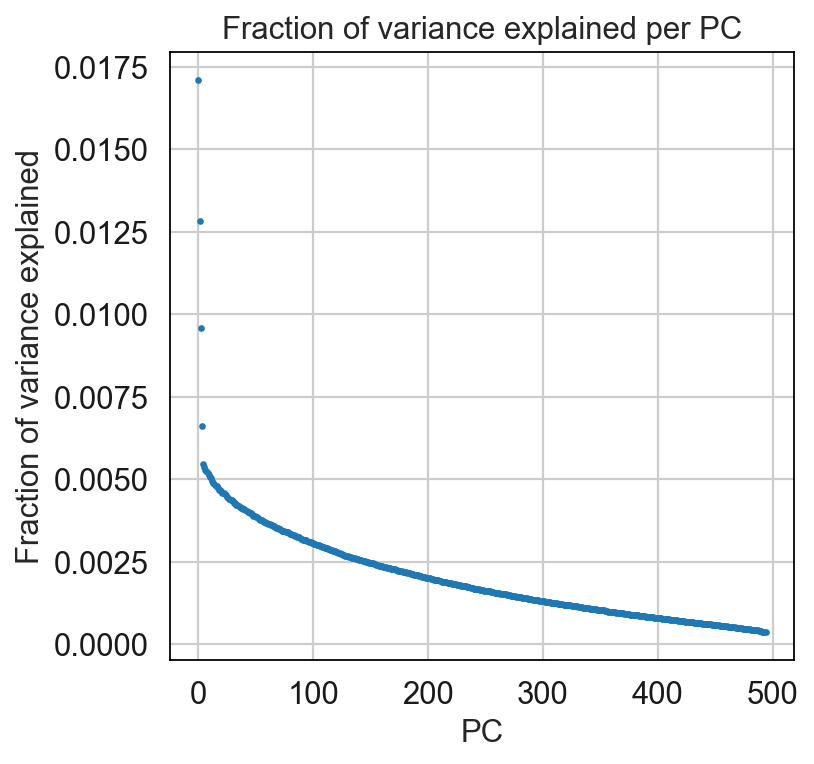

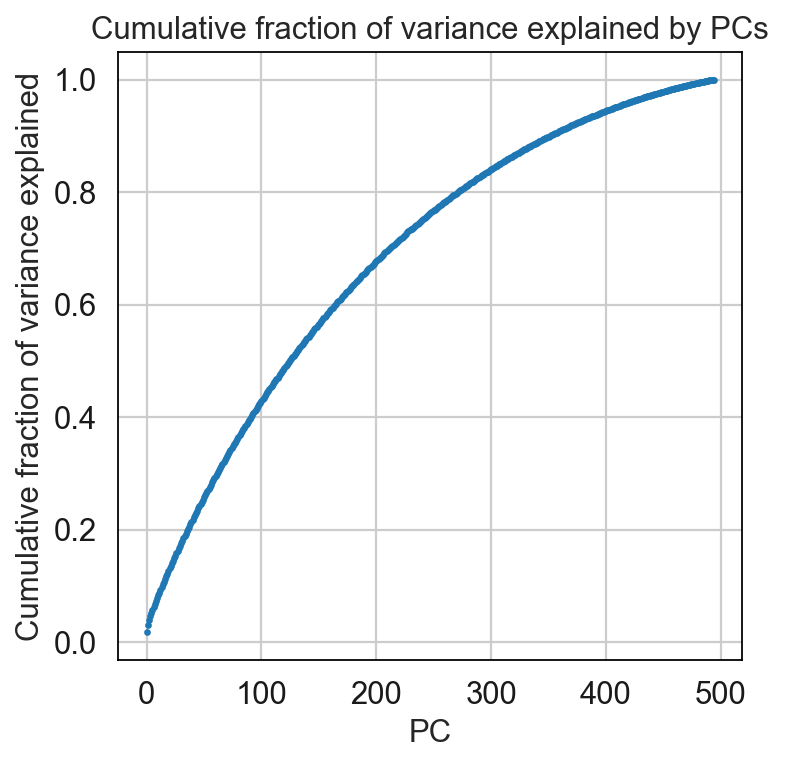

Knee point: 26
Explained variance: 0.15818554


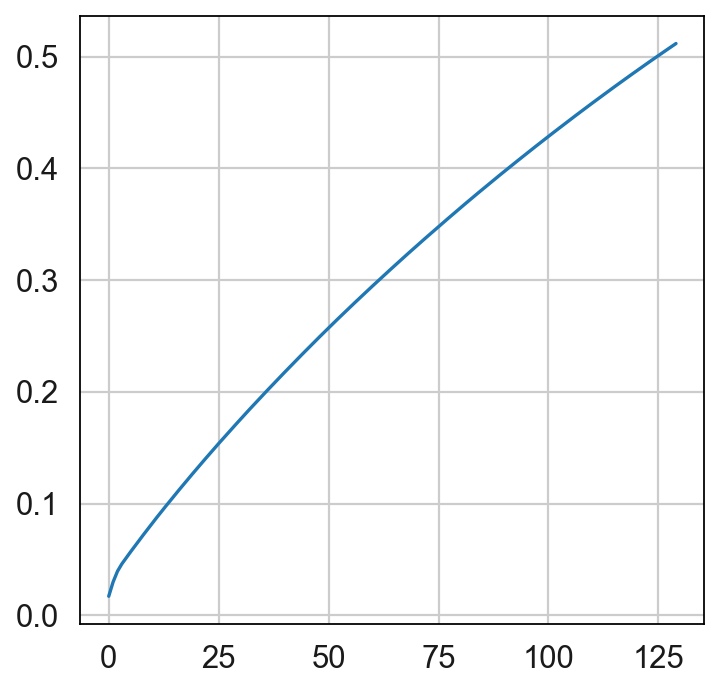

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8942 missing from current font.
  font.set_text(s, 0, flags=flags)


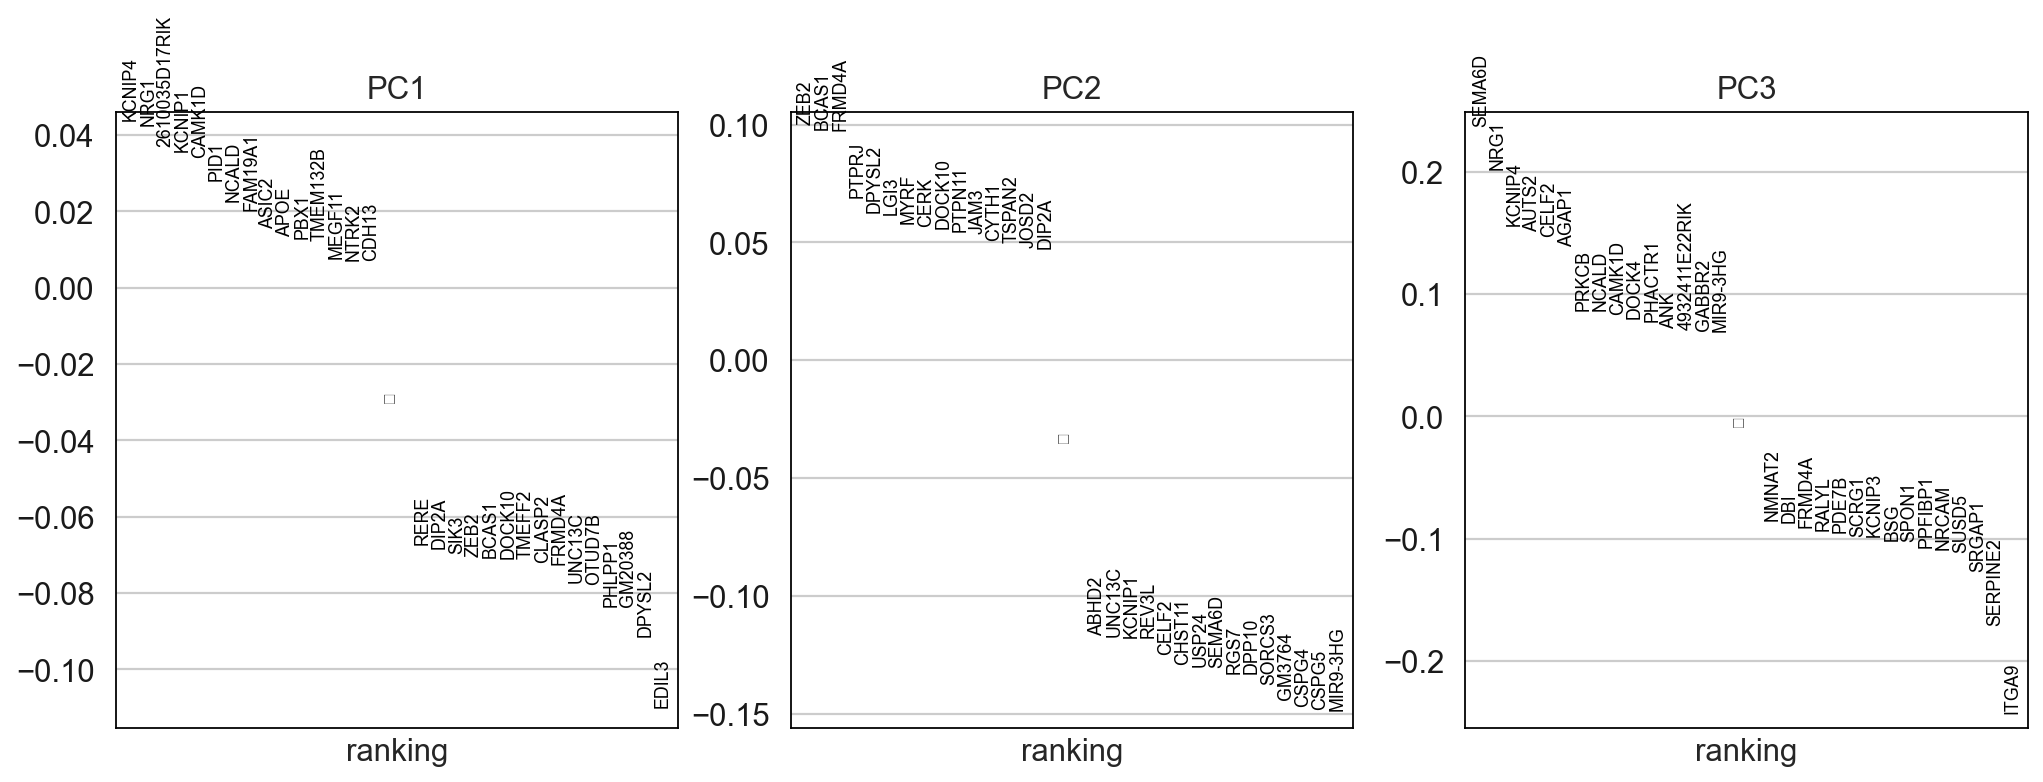

(496, 10496)


/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [22]:
sc.set_figure_params(figsize=(5, 5))
adata_opc = run_pca_knee(adata_opc)#, 0.5)
adata_opc.obs['PC 1'] = adata_opc.obsm['X_pca'][:,0] # optional
adata_opc.obs['PC 2'] = adata_opc.obsm['X_pca'][:,1]
adata_opc.obs['PC 3'] = adata_opc.obsm['X_pca'][:,2]

print(adata_opc.shape)
adata_opc.X = pd.DataFrame(adata_opc.X).fillna(0).values
index_list = np.arange(adata_opc.shape[0])
np.random.shuffle(index_list)
adata_opc = adata_opc[index_list,:]

In [23]:
print(adata_opc.shape)
adata_opc.X = pd.DataFrame(adata_opc.X).fillna(0).values
index_list = np.arange(adata_opc.shape[0])
np.random.shuffle(index_list)
adata_opc = adata_opc[index_list,:]

(496, 10496)


## Phenograph

Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.08016800880432129 seconds
Jaccard graph constructed in 3.1961469650268555 seconds
Wrote graph to binary file in 0.00926828384399414 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.633672
After 2 runs, maximum modularity is Q = 0.63545
After 3 runs, maximum modularity is Q = 0.637035
Louvain completed 23 runs in 0.5172791481018066 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 4.4650139808654785 seconds


Trying to set attribute `.obs` of view, copying.


Finding 15 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.010828018188476562 seconds
Jaccard graph constructed in 0.8563318252563477 seconds
Wrote graph to binary file in 0.012079238891601562 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.577296
After 6 runs, maximum modularity is Q = 0.578438
Louvain completed 26 runs in 0.35183000564575195 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 1.8826491832733154 seconds
Finding 20 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.011404991149902344 seconds
Jaccard graph constructed in 0.8243749141693115 seconds
Wrote graph to binary file in 0.016164064407348633 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.526778
After 4 runs, maximum modularity is Q = 0.528701
After 19 runs, maximum modularity is Q = 0.530578
Louvain completed 39 runs in 0.5225672721862

Text(0.5, 0, 'k')

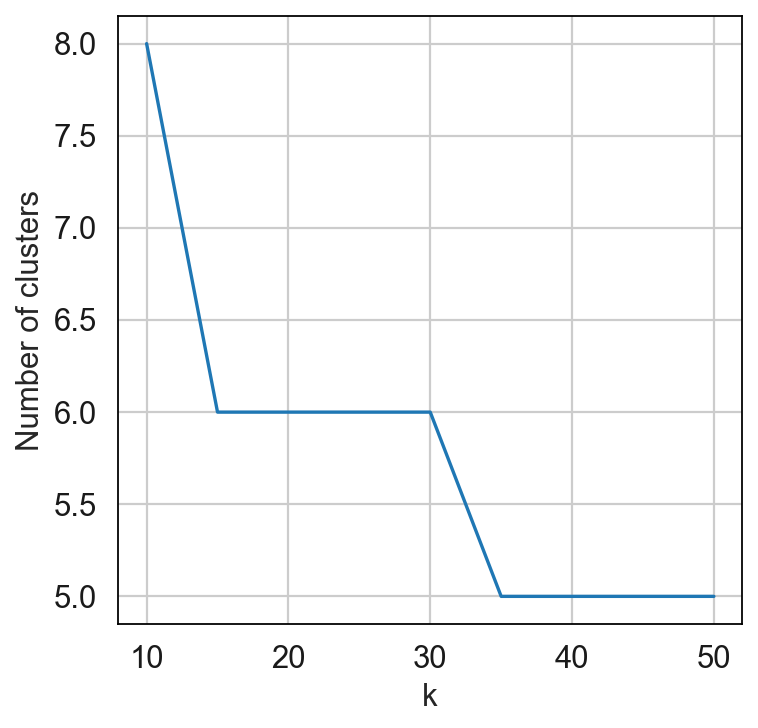

In [24]:
k_list = list(range(10, 55, 5))
n_clusters = []
for k in k_list:
    communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata_opc.obsm['X_pca']),k=k)
    n_clusters.append(len(np.unique(communities)))
    adata_opc.obs['PhenoGraph_clusters_opc'+str(k)] = pd.Categorical(communities)
    adata_opc.uns['PhenoGraph_Q_'+str(k)] = Q
    adata_opc.uns['PhenoGraph_k_'+str(k)] = k
plt.plot(k_list,n_clusters)
plt.ylabel("Number of clusters")
plt.xlabel("k")

In [25]:
Rand_index_df = pd.DataFrame(np.zeros((len(k_list), len(k_list))),index=k_list,columns=k_list)
Rand_index_df.index.name='k1'
Rand_index_df.columns.name='k2'
row_ind = 0
for run1 in range(len(k_list)):
    col_ind = 0
    for run2 in range(len(k_list)):
        Rand_index_df.iloc[row_ind,col_ind] = adjusted_rand_score(
            adata_opc.obs['PhenoGraph_clusters_opc'+str(k_list[run1])].values,
            adata_opc.obs['PhenoGraph_clusters_opc'+str(k_list[run2])].values)
        col_ind = col_ind+1
    row_ind = row_ind+1
    

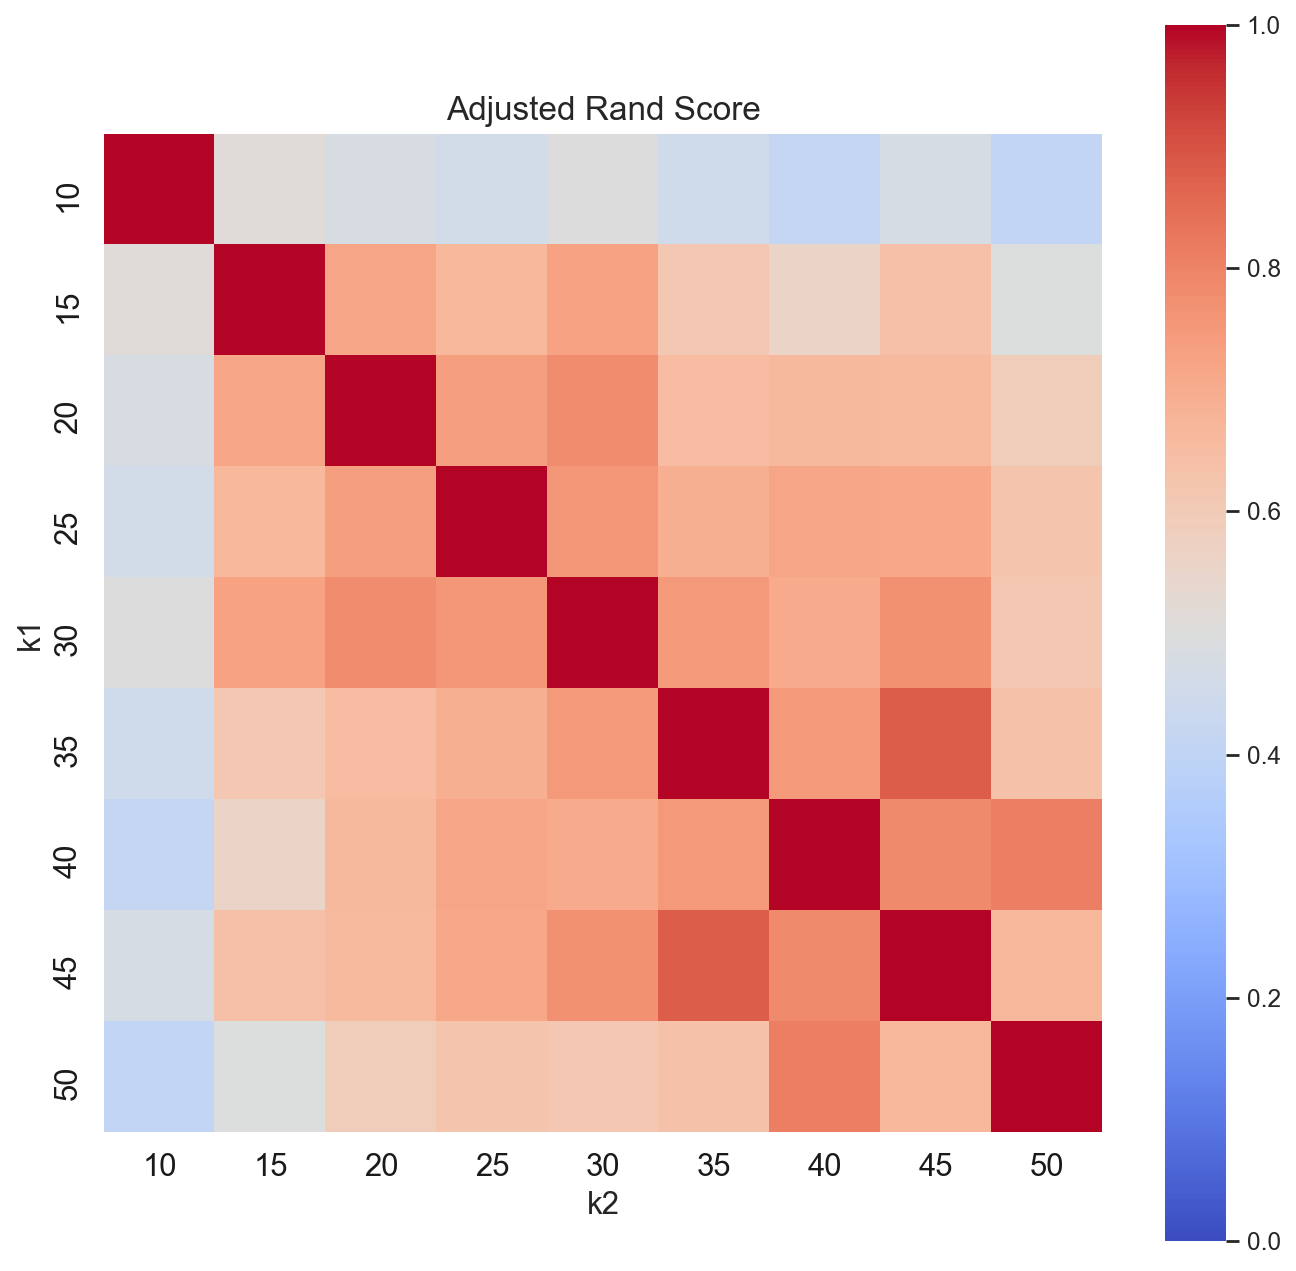

In [26]:
Rand_fig = plt.figure(figsize = (10,10))
plt.xlabel('k1')
plt.ylabel('k2')
plt.title('Adjusted Rand Score',fontsize=15)
sns.set(font_scale=1)
sns.heatmap(Rand_index_df, cmap=('coolwarm'), square=True, vmin=0, vmax=1)
# plt.colorbar(vmin=0)
plt.show();plt.close()


In [29]:
k = 30 # choose k
communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata_opc.obsm['X_pca']),k=k) # run PhenoGraph
adata_opc.obs['PhenoGraph_clusters_opc'] = pd.Categorical(communities)
adata_opc.uns['PhenoGraph_Q'] = Q
adata_opc.uns['PhenoGraph_k'] = k

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.07424187660217285 seconds
Jaccard graph constructed in 0.8526179790496826 seconds
Wrote graph to binary file in 0.02565479278564453 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.448363
After 2 runs, maximum modularity is Q = 0.451168
Louvain completed 22 runs in 0.3394129276275635 seconds
Sorting communities by size, please wait ...
PhenoGraph complete in 1.9566097259521484 seconds


## Vizualize Oligo sub-clusters

In [30]:
sc.set_figure_params(figsize=(8, 8))
sc.pp.neighbors(adata_opc, method='umap', use_rep='X_pca')
sc.tl.umap(adata_opc, random_state=None)

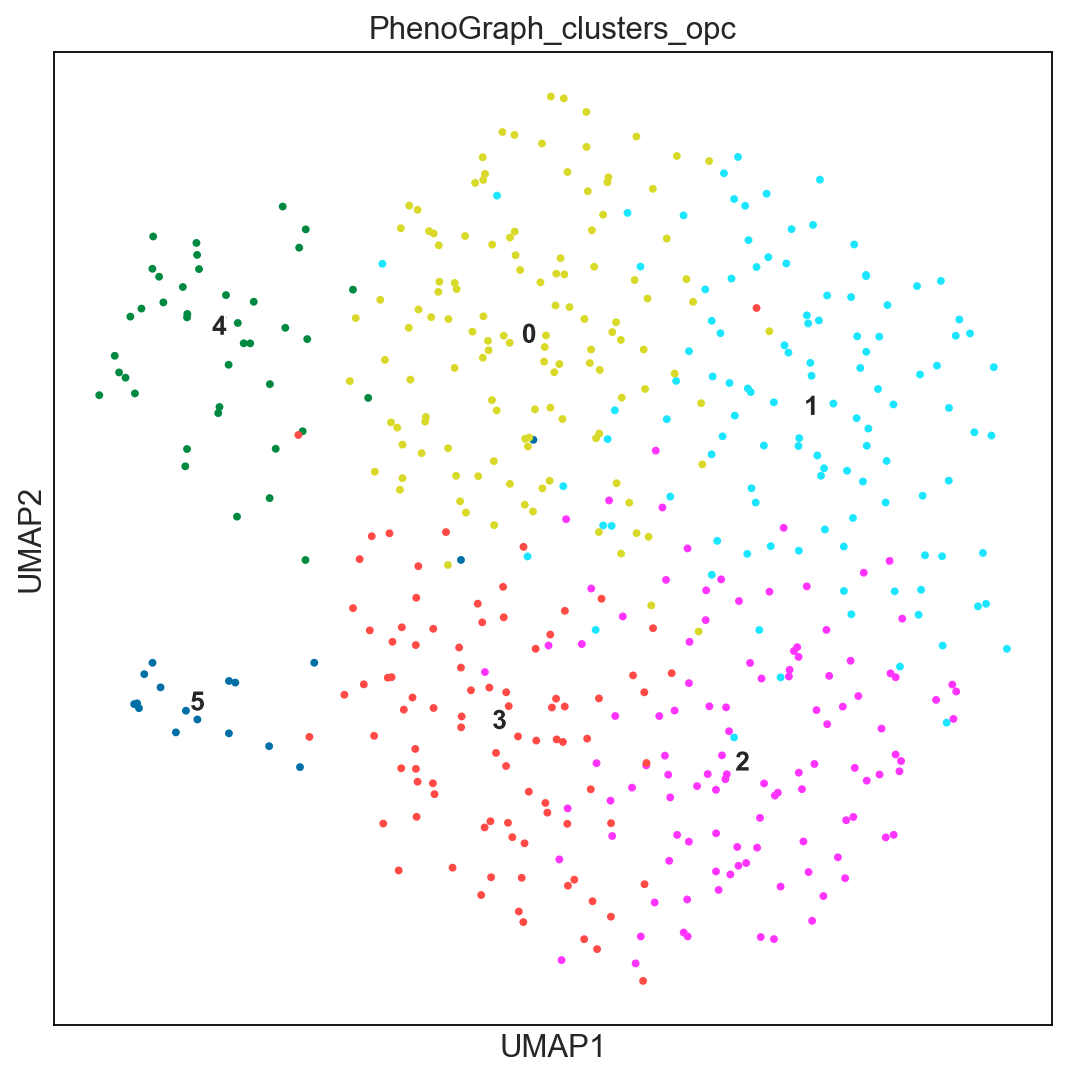

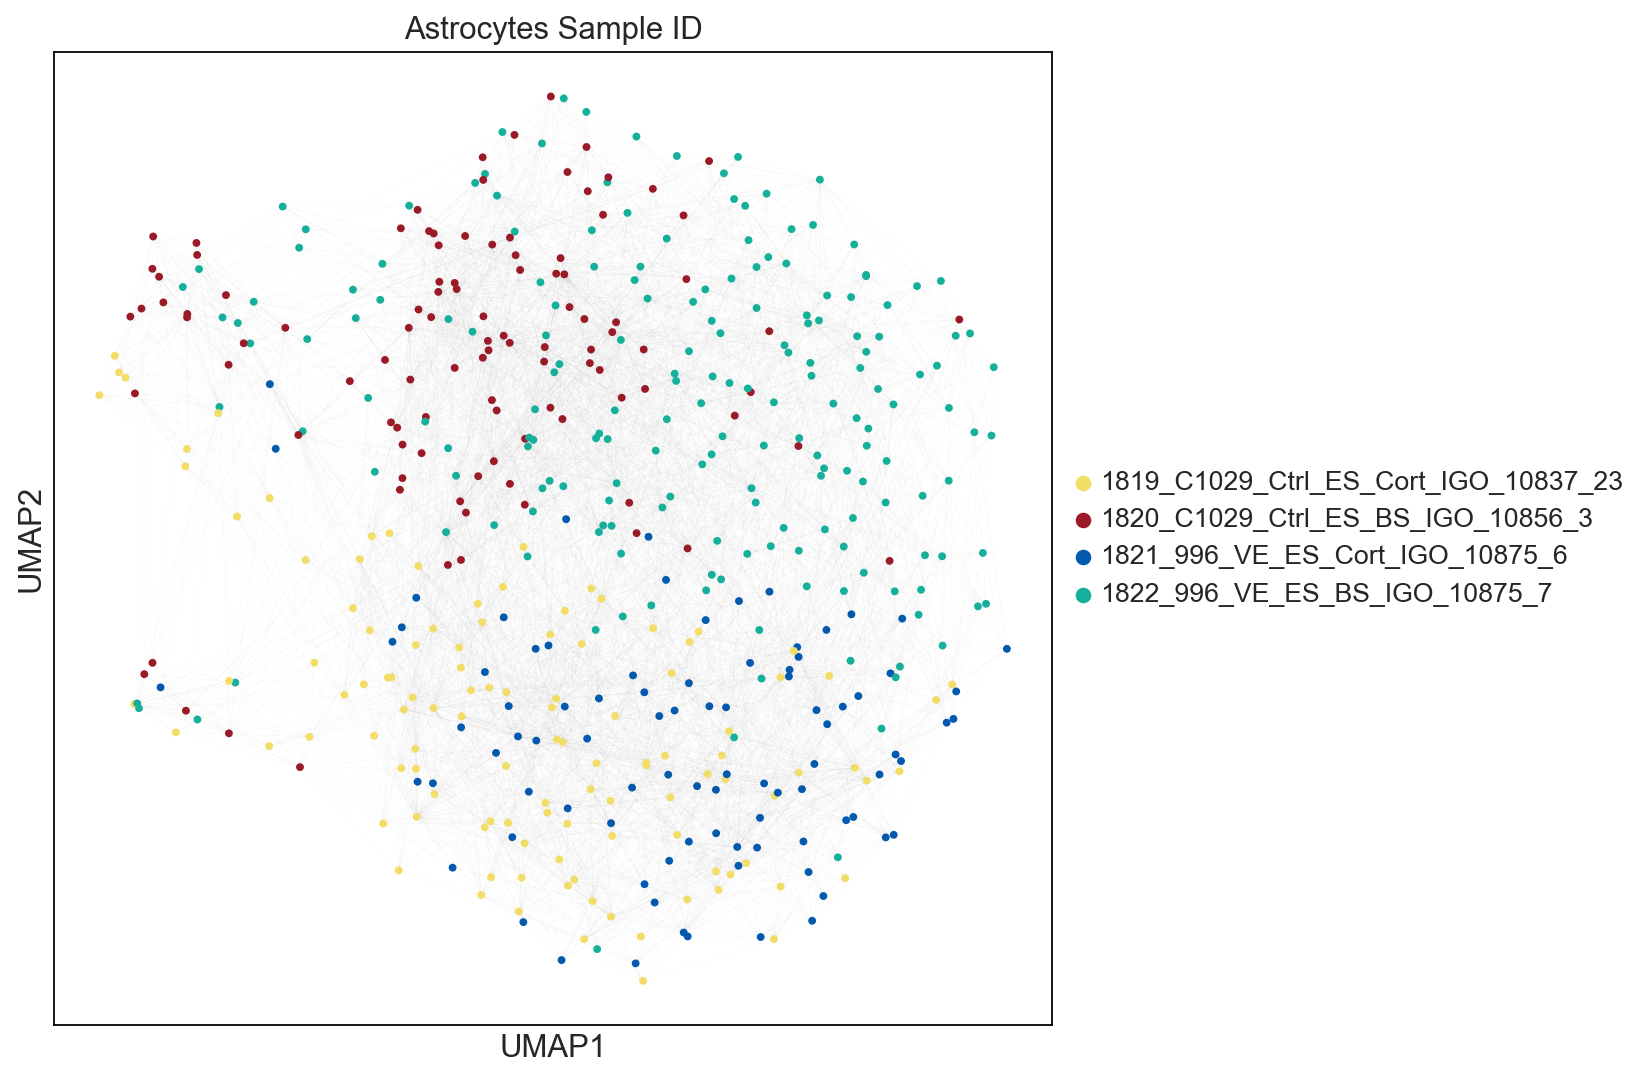

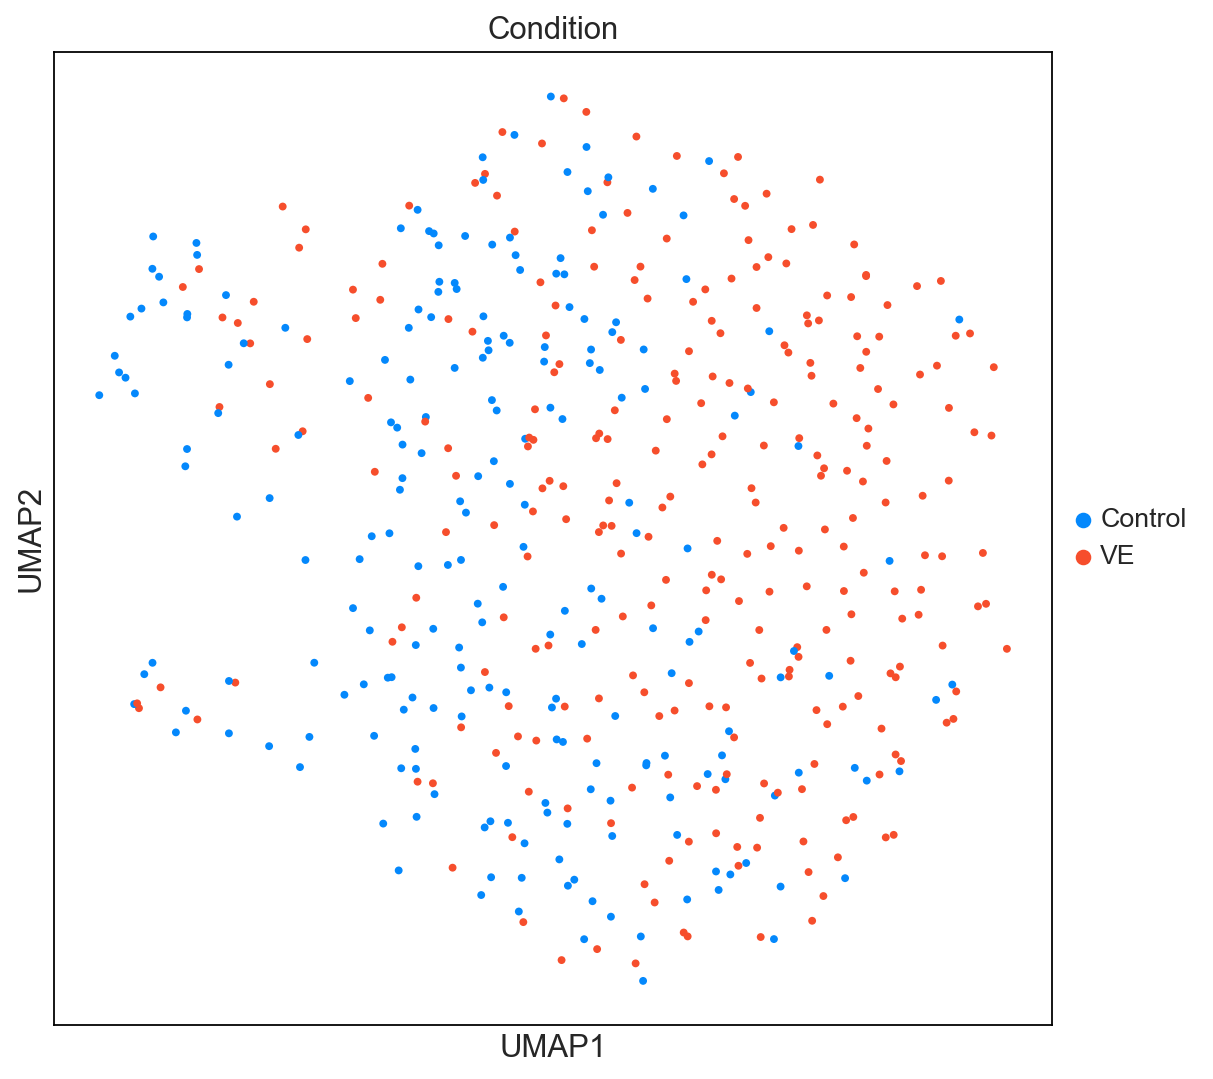

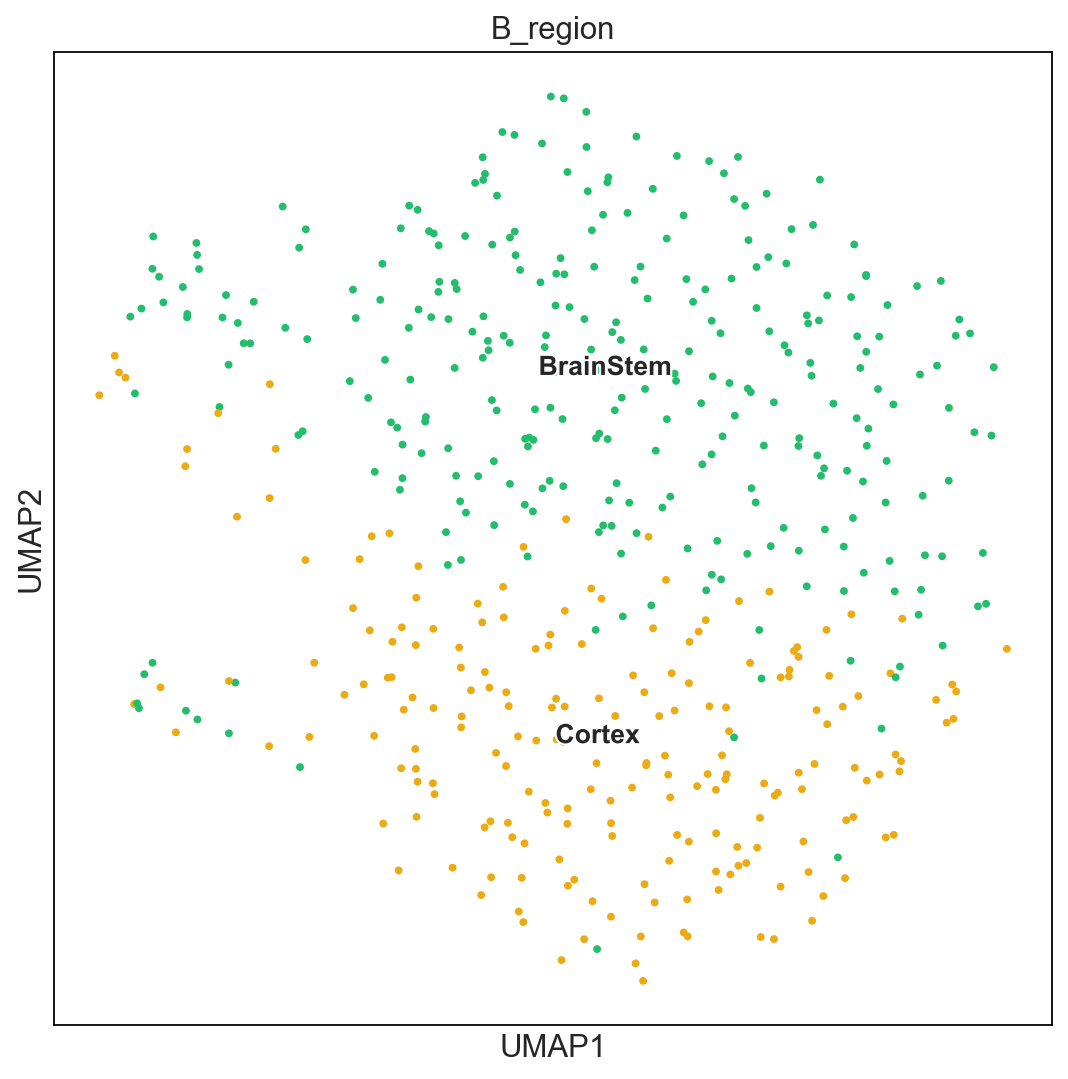

In [35]:
sc.pl.umap(adata_opc,
           color=['PhenoGraph_clusters_opc'],
           ncols=2,
           sort_order=False,
           palette=godsnot_64, # 'palette' specifies the colormap to use
           cmap='Spectral_r',
           legend_loc='on data',
           legend_fontsize=12, size = 50,
           legend_fontoutline=2,)

sc.pl.umap(adata_opc, 
           color= ['Sample ID'],
           ncols=2,
           edges = True,
           edges_width= 0.01,
           palette= ["#F2DD66", "#9A1B27", "#0359AE", "#14B09B"],
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Astrocytes Sample ID"])

sc.pl.umap(adata_opc,
           color=['Condition'],
           ncols=2,
           sort_order=False,
           palette=['#0488FC','#F64E2C'], # 'palette' specifies the colormap to use
           cmap='Spectral_r',
           legend_fontsize=12, size = 50,
           legend_fontoutline=2)

sc.pl.umap(adata_opc,
           color=['B_region'],
           ncols=2,
           sort_order=False,
           palette= ["#22BE6E", "#EDAB13"], # 'palette' specifies the colormap to use
           cmap='Spectral_r',
           legend_loc='on data',
           legend_fontsize=12, size = 50,
           legend_fontoutline=2)



## Find markers (Oligo clusters)

In [37]:
cl_int_to_str = dict()
cl_int_to_str = {
    0 : 'Opc0',
    1 : 'Opc1',
    2 : 'Opc2',
    3 : 'Opc3',
    4 : 'Opc4',
    5 : 'Opc5'}

adata_opc.obs['PhenoGraph_clusters_opc_str'] = adata_opc.obs['PhenoGraph_clusters_opc'].map(cl_int_to_str).astype('category')

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:407: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


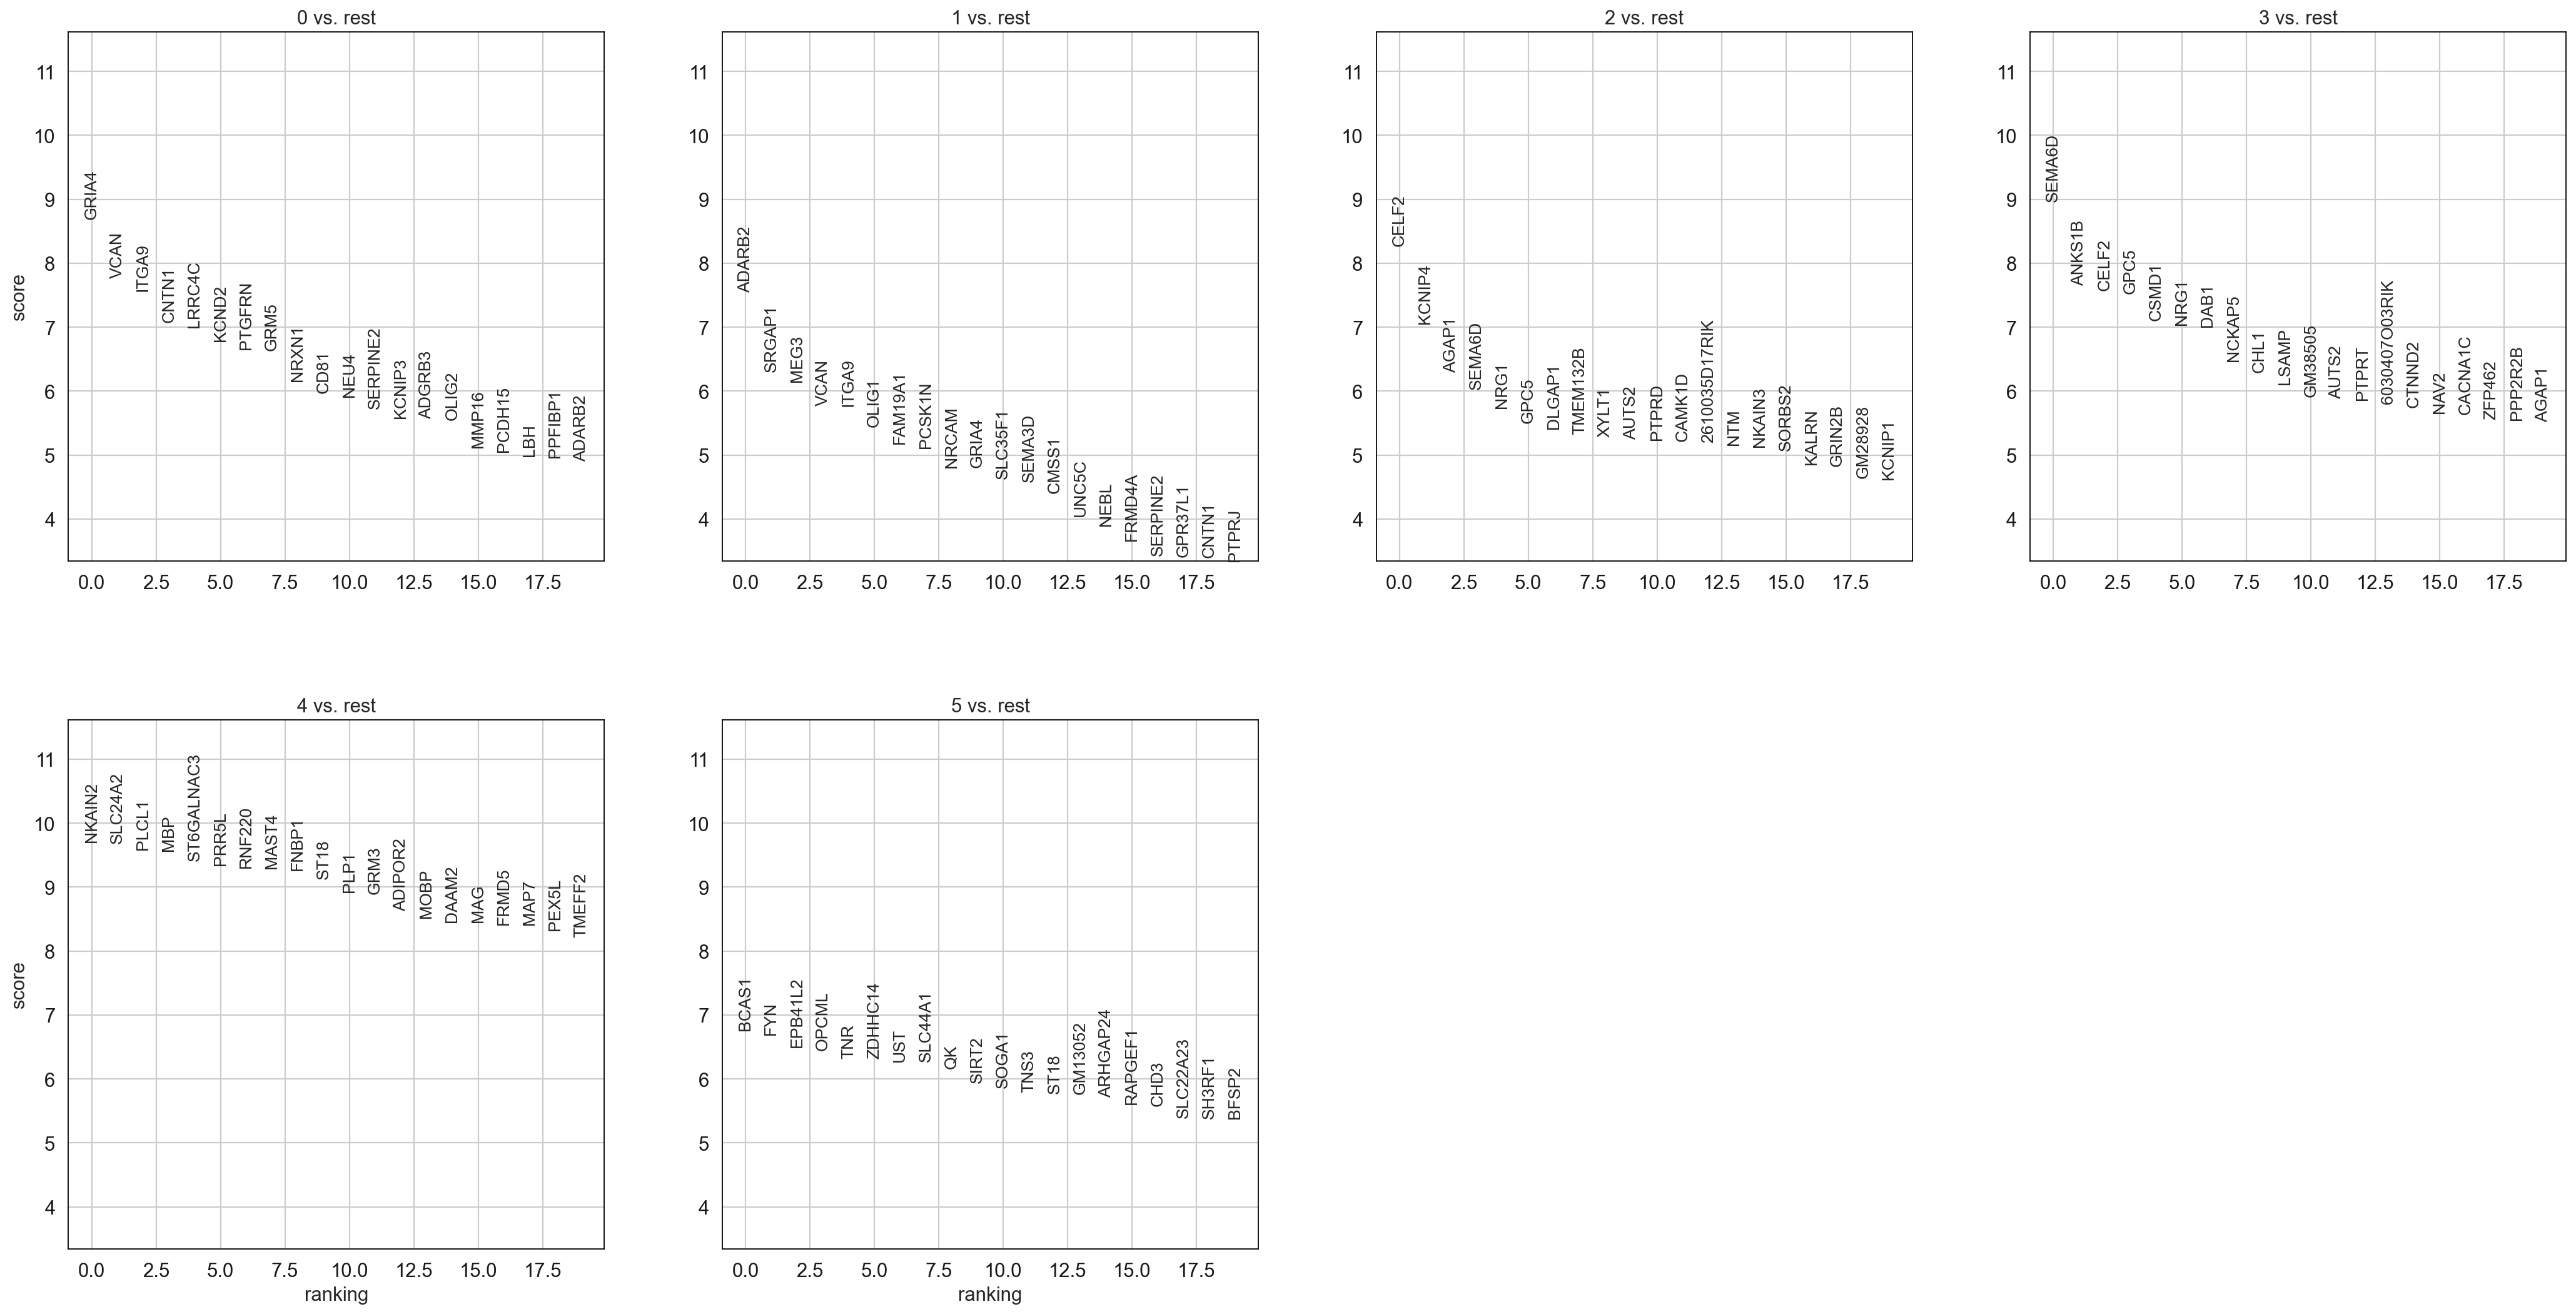

In [38]:
sc.tl.rank_genes_groups(adata_opc, groupby='PhenoGraph_clusters_opc', key_added="ranked_genes_pheno_opc", method='wilcoxon')
sc.pl.rank_genes_groups(adata_opc, key = 'ranked_genes_pheno_opc', fontsize=12)

## Visualize marker genes using heatmap

In [39]:
adata_opc.layers['scaled'] = sc.pp.scale(adata_opc, copy=True).X

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


{'heatmap_ax': <AxesSubplot:>,
 'groupby_ax': <AxesSubplot:xlabel='PhenoGraph_clusters_opc_str'>,
 'dendrogram_ax': <AxesSubplot:>,
 'gene_groups_ax': <AxesSubplot:>}

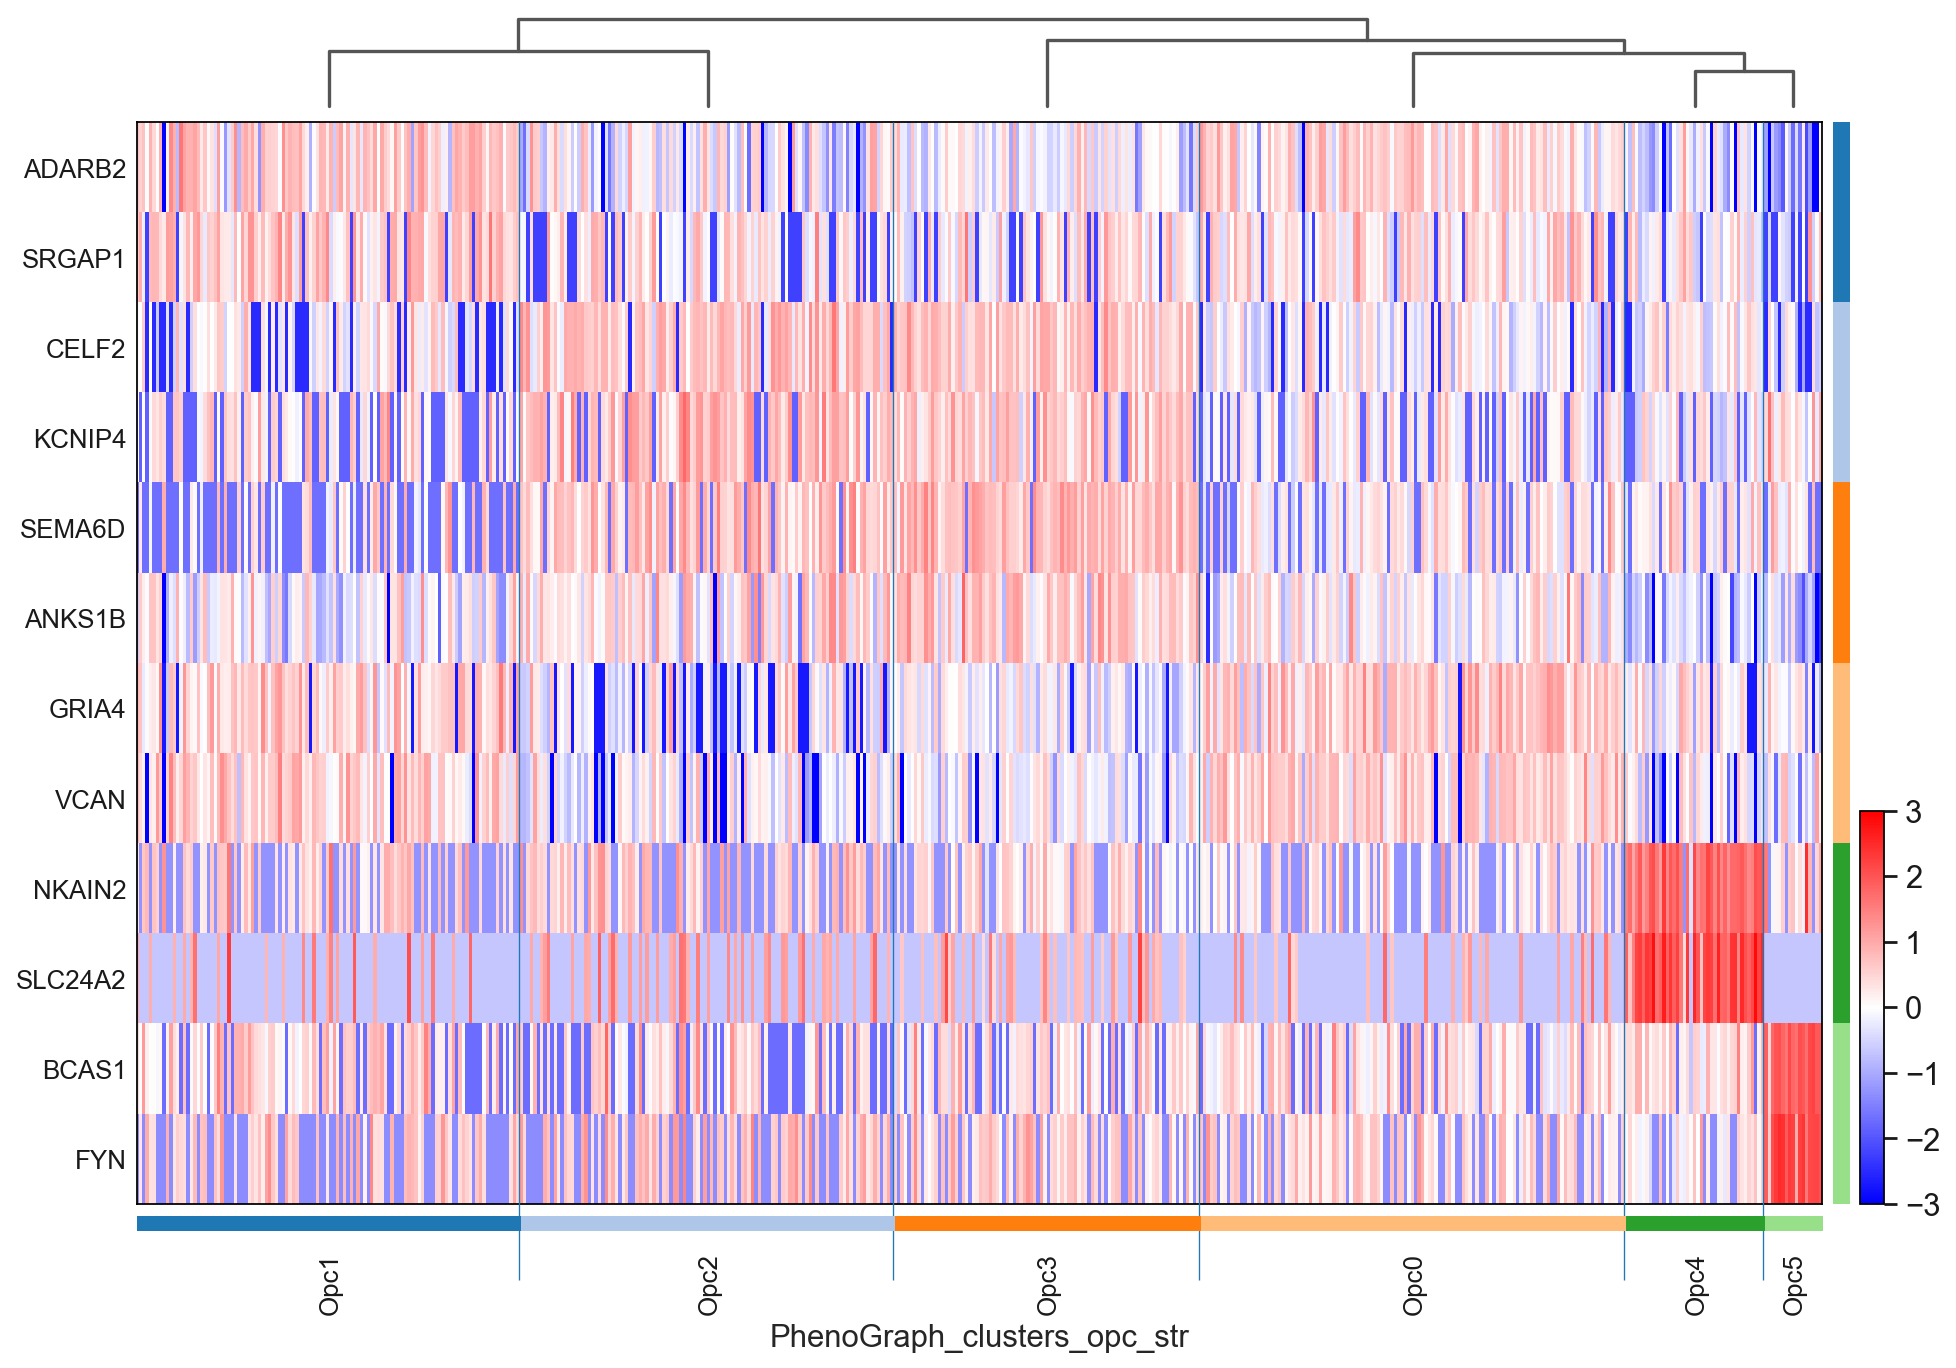

In [41]:
sc.tl.rank_genes_groups(adata_opc, groupby='PhenoGraph_clusters_opc_str', n_genes=adata_opc.shape[1], method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata_opc, n_genes=2, use_raw=False, swap_axes=True, vmin=-3, vmax=3, cmap='bwr', layer='scaled', figsize=(14,10), show=False)

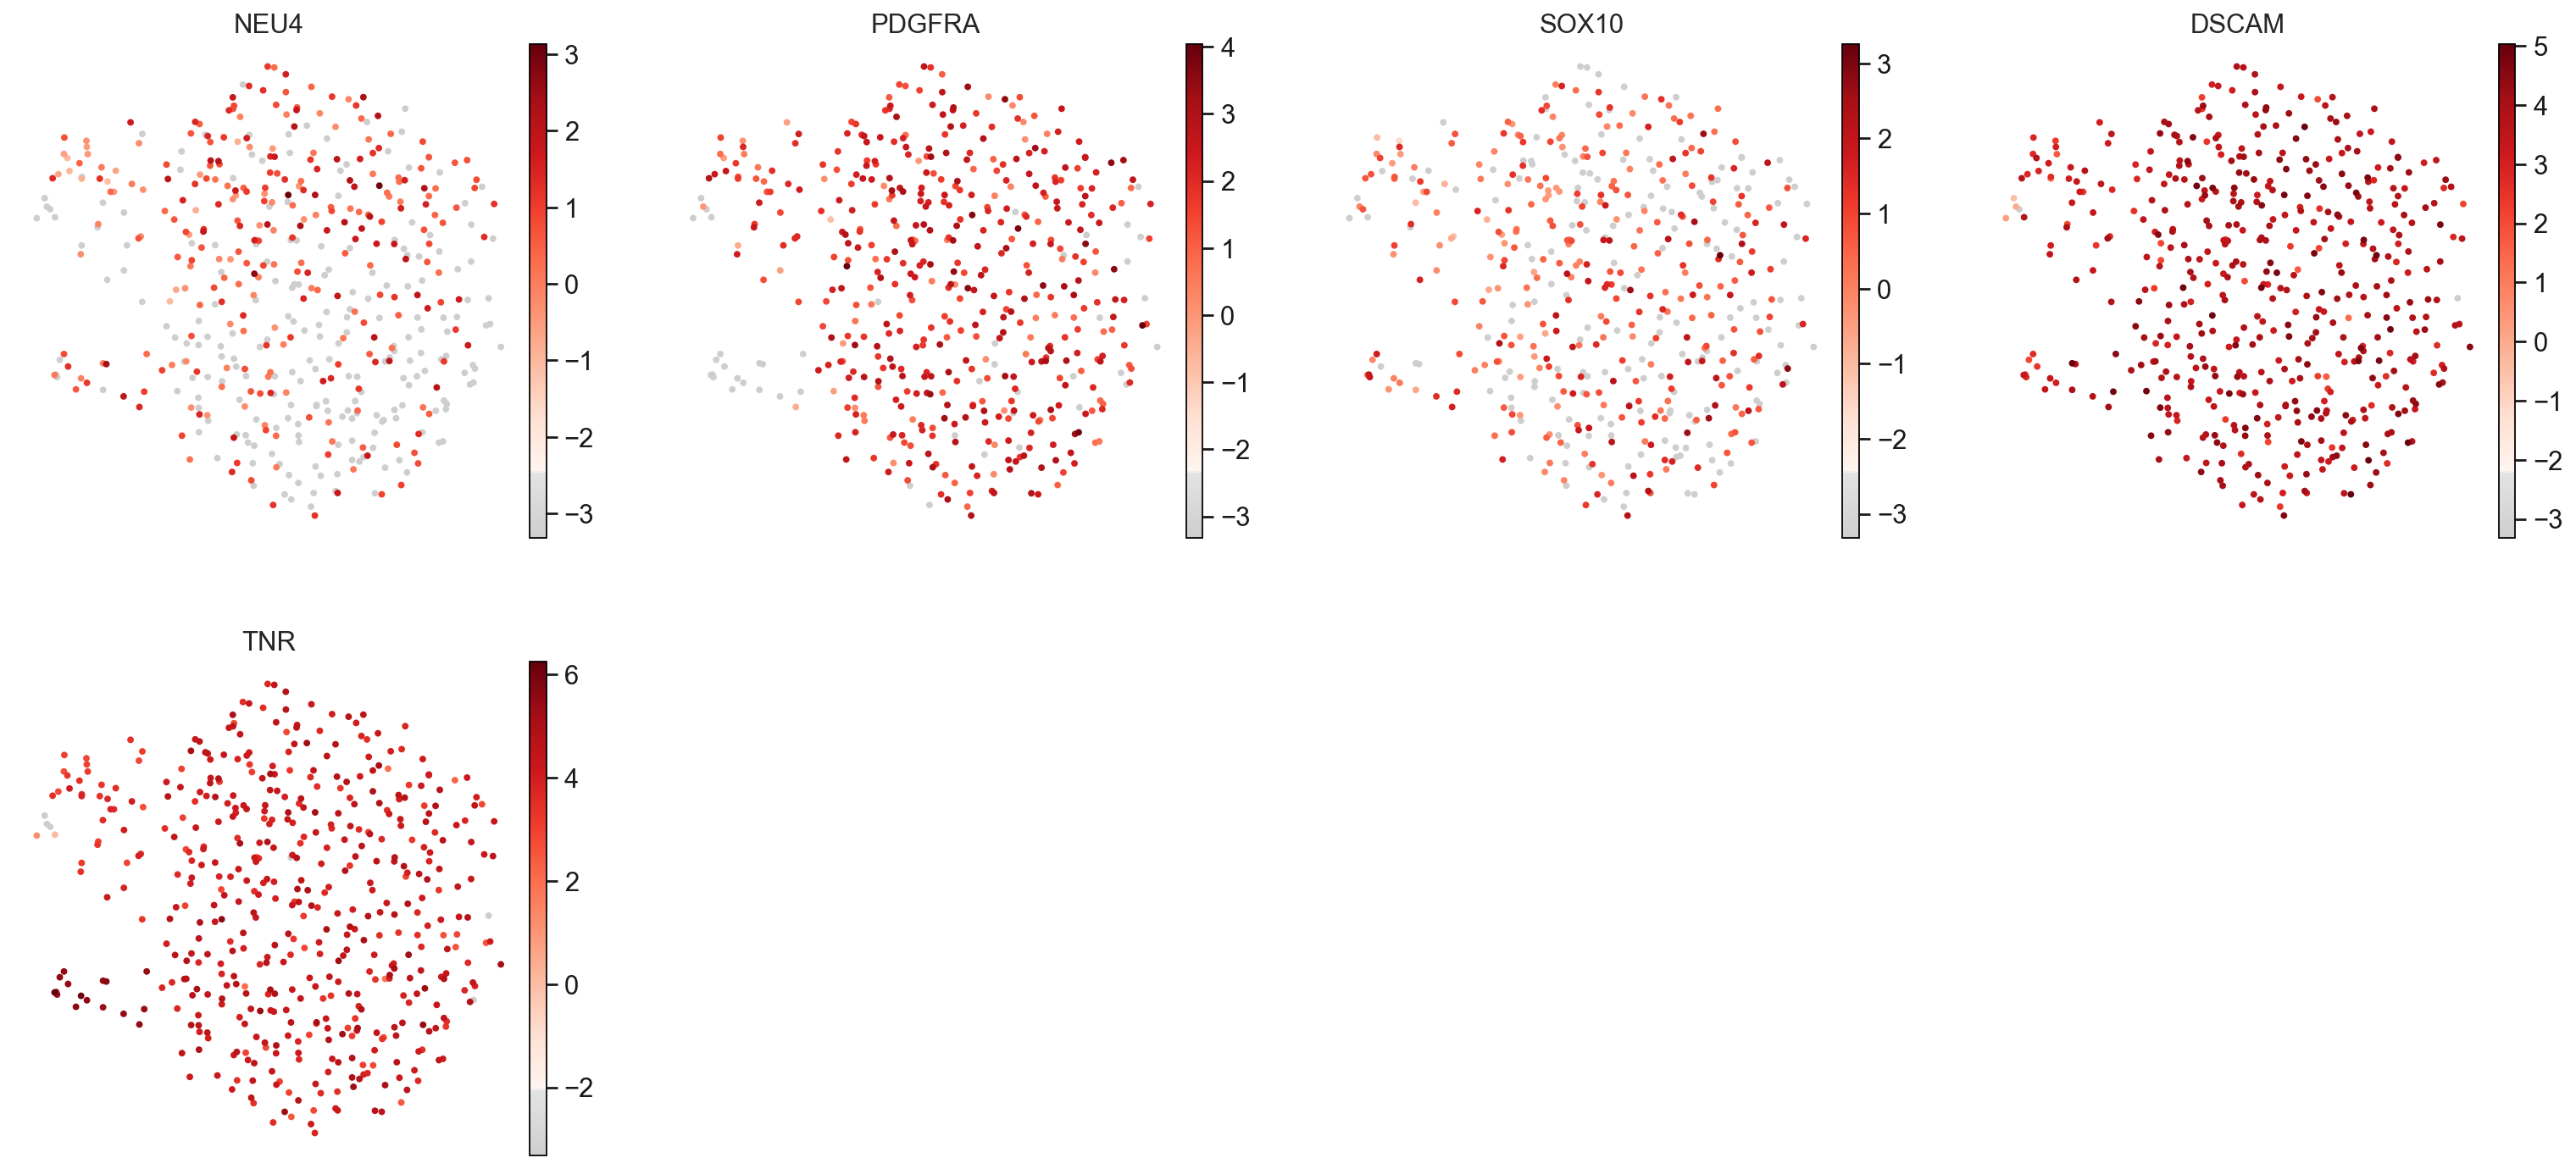

In [46]:
sc.set_figure_params(figsize=(5, 5))
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = matplotlib.colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
 
sc.pl.umap(adata_opc,
           size = 50,
           color=['NEU4','PDGFRA','SOX10','DSCAM','TNR'],
           color_map=mymap,
          frameon=False, )

## Save result Adata Oligodendrocytes

In [47]:
#adata_opc.write_h5ad(outdir+'adata_high_var_OPC_clusters.h5ad')

In [ ]:
adata_opc = sc.read_h5ad(outdir+'adata_high_var_OPC_clusters.h5ad')

## Differential expression with MAST for Cortex & Brainstem

Load the adata object that holds the latest cell type annotations..

In [49]:
run_MAST_for_celltype(adata_opc, "OPC")

OPC	Dimensions	(496, 10496)
Files written for OPC
Running ./runMAST.R DEA/OPC/adata_OPC_exp_mat.csv DEA/OPC/adata_OPC_cdata.csv DEA/OPC/MAST_DEA_OPC_cort.csv DEA/OPC/MAST_DEA_OPC_bs.csv


'Finished running MAST on( OPC) in 240.62521298899992 seconds.'

## OPC Brainstem

In [50]:
adata_opc_BS = adata_opc.copy()
adata_opc_BS = adata_opc_BS[adata_opc_BS.obs['B_region'].isin(['BrainStem']),:]
adata_opc_BS.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(292, 10496)

In [51]:
adata_opc_BS.obs.Condition.value_counts()

VE         187
Control    105
Name: Condition, dtype: int64

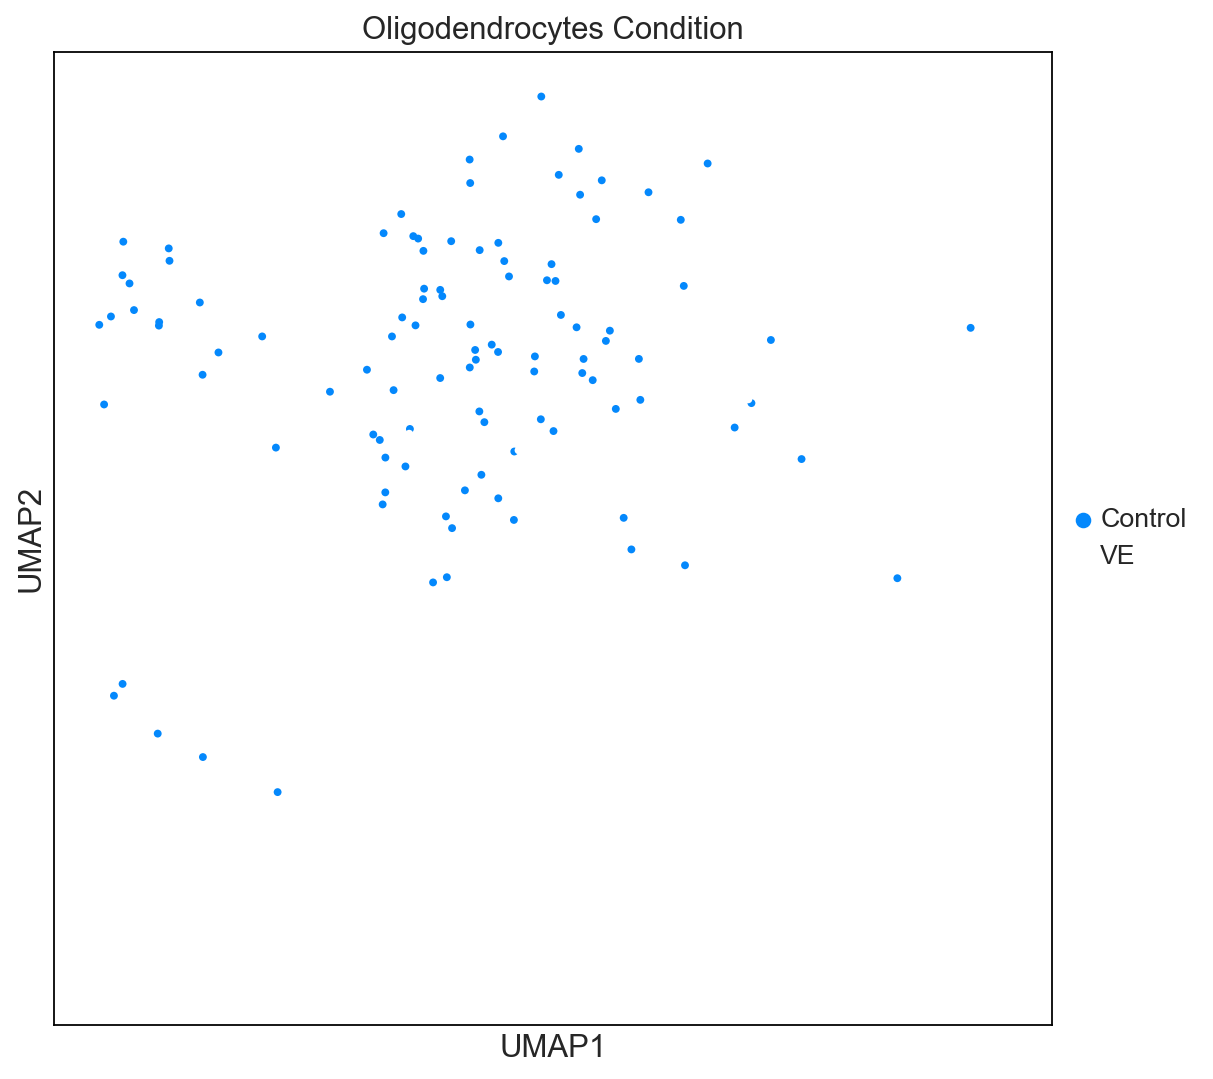

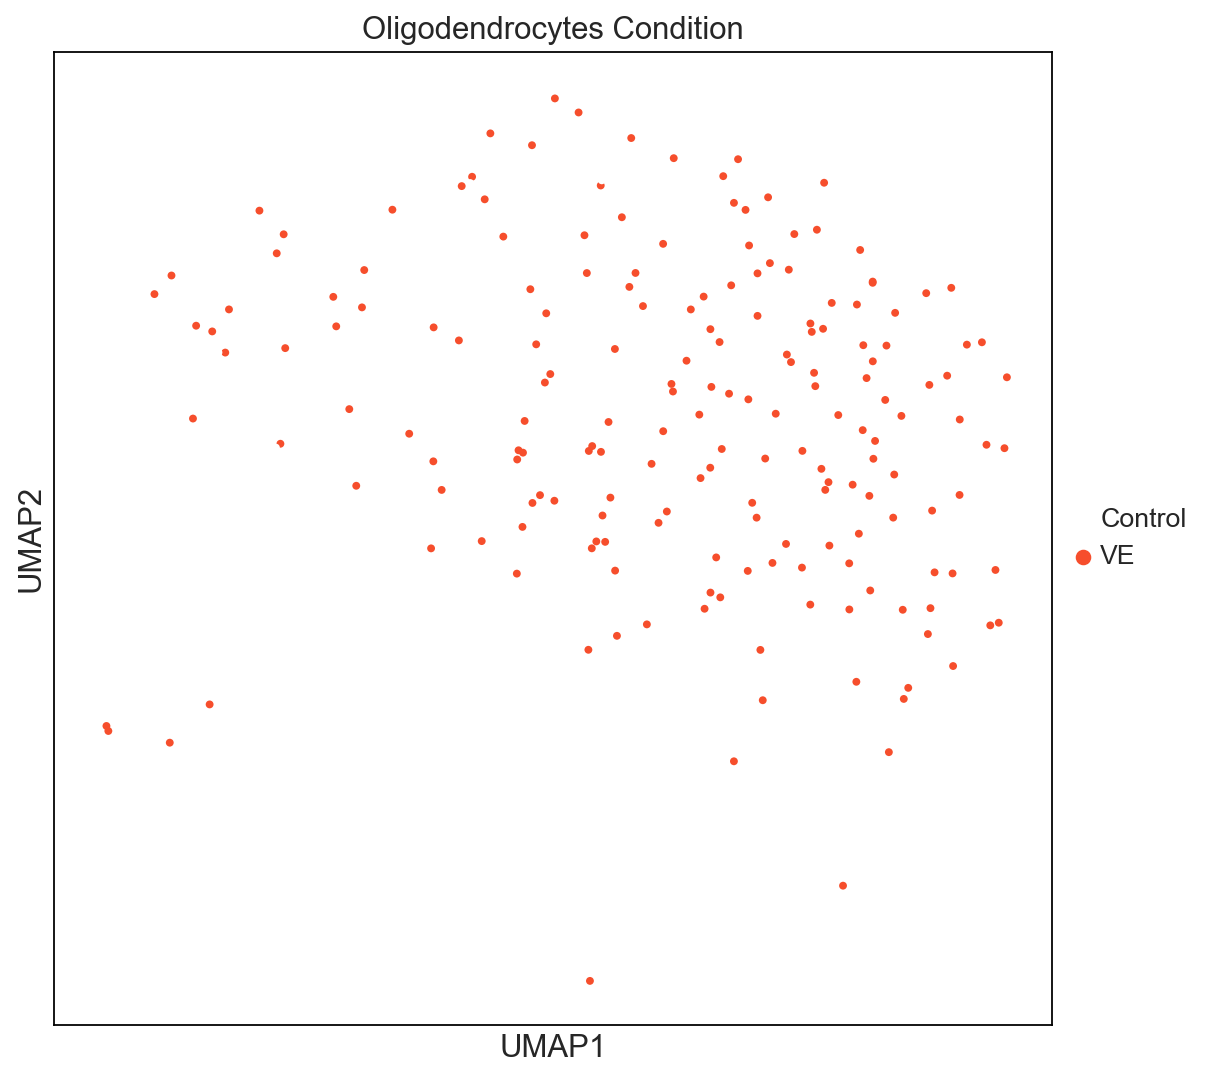

In [54]:
sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_opc_BS, 
           color= ['Condition'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=['#0488FC','#FFFFFFFF'],
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Oligodendrocytes Condition"])


sc.pl.umap(adata_opc_BS, 
           color= ['Condition'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=['#FFFFFFFF','#F64E2C'],
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["Oligodendrocytes Condition"])

### OPC BS control 

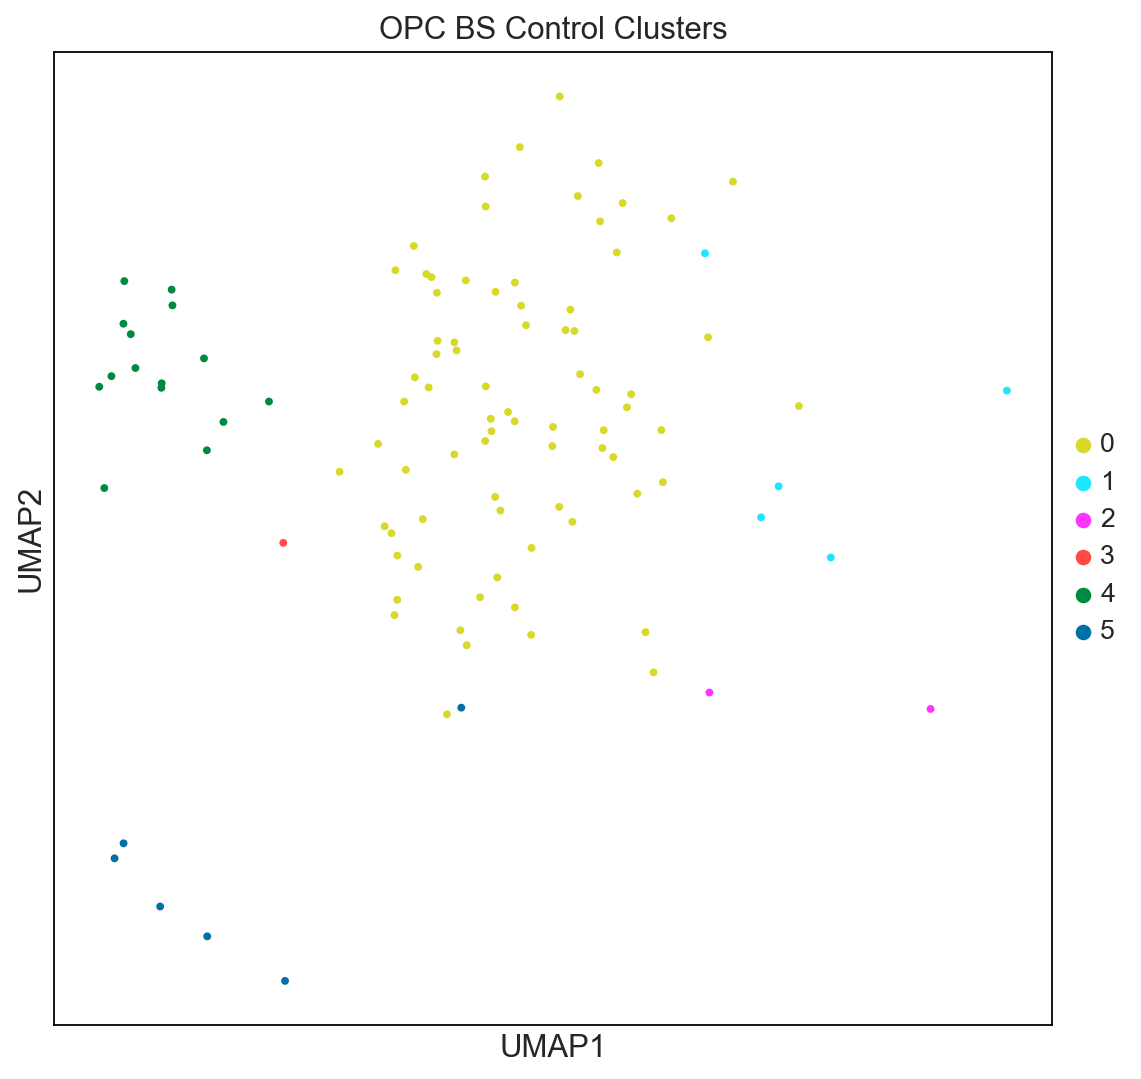

In [55]:
adata_opc_BS_control = adata_opc_BS[adata_opc_BS.obs['Condition'].isin(['Control']),:].copy()

sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_opc_BS_control, 
           color= ['PhenoGraph_clusters_opc'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=godsnot_64,
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["OPC BS Control Clusters"])

In [56]:
cell_counts_per_cluster_BS_ctrl = adata_opc_BS_control.obs.PhenoGraph_clusters_opc.value_counts()
cell_counts_per_cluster_BS_ctrl = cell_counts_per_cluster_BS_ctrl.to_frame()
cell_counts_per_cluster_BS_ctrl

,PhenoGraph_clusters_opc
0,76
4,15
5,6
1,5
2,2
3,1


### OPC BS VE

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


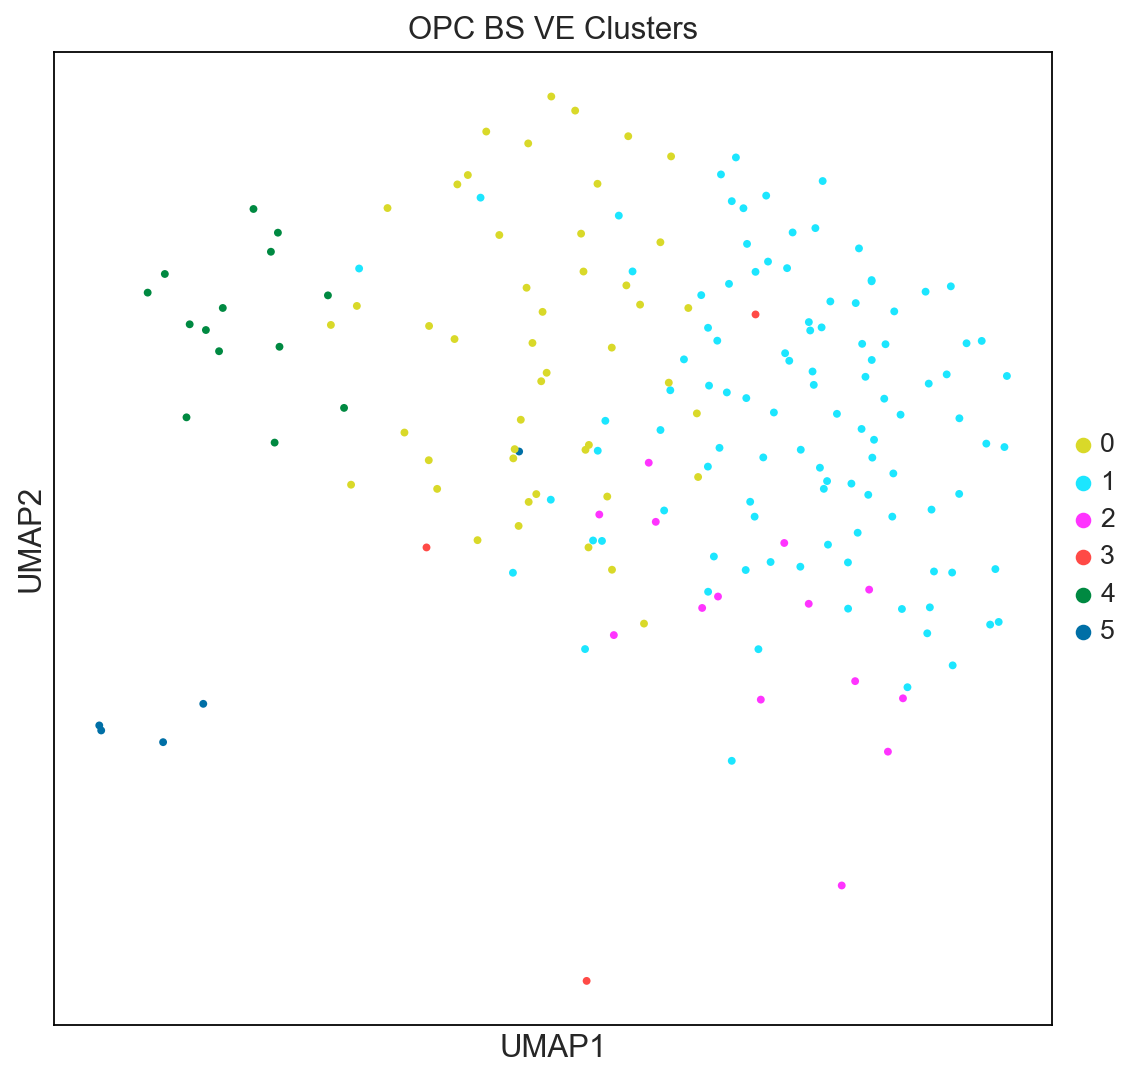

In [57]:
adata_opc_BS_VE = adata_opc_BS[adata_opc_BS.obs['Condition'].isin(['VE']),:].copy()

sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_opc_BS_VE, 
           color= ['PhenoGraph_clusters_opc'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=godsnot_64,
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["OPC BS VE Clusters"])

In [58]:
cell_counts_per_cluster_BS_VE = adata_opc_BS_VE.obs.PhenoGraph_clusters_opc.value_counts()
cell_counts_per_cluster_BS_VE = cell_counts_per_cluster_BS_VE.to_frame()
cell_counts_per_cluster_BS_VE

,PhenoGraph_clusters_opc
1,104
0,47
2,14
4,14
5,5
3,3


### Heatmaps of gene expression

In [ ]:
marker_genes_dict = dict()

marker_genes_dict = {'OPC-BS':[
]}



In [ ]:
adata_opc_BS.layers['scaled'] = sc.pp.scale(adata_opc_BS, copy=True).X
sc.pl.matrixplot(adata_opc_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_opc_str','Condition'], dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_opc_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_opc_str','Condition'], dendrogram=True,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot(adata_opc_BS, marker_genes_dict, groupby=['PhenoGraph_clusters_opc_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

In [ ]:
adata_opc_BS.obs.PhenoGraph_clusters_opc.value_counts()

## OPC Cortex

In [59]:
adata_opc_cortex = adata_opc.copy()
adata_opc_cortex = adata_opc_cortex[adata_opc_cortex.obs['B_region'].isin(['Cortex']),:]
adata_opc_cortex.shape

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(204, 10496)

In [60]:
adata_opc_cortex.obs.Condition.value_counts()

Control    114
VE          90
Name: Condition, dtype: int64

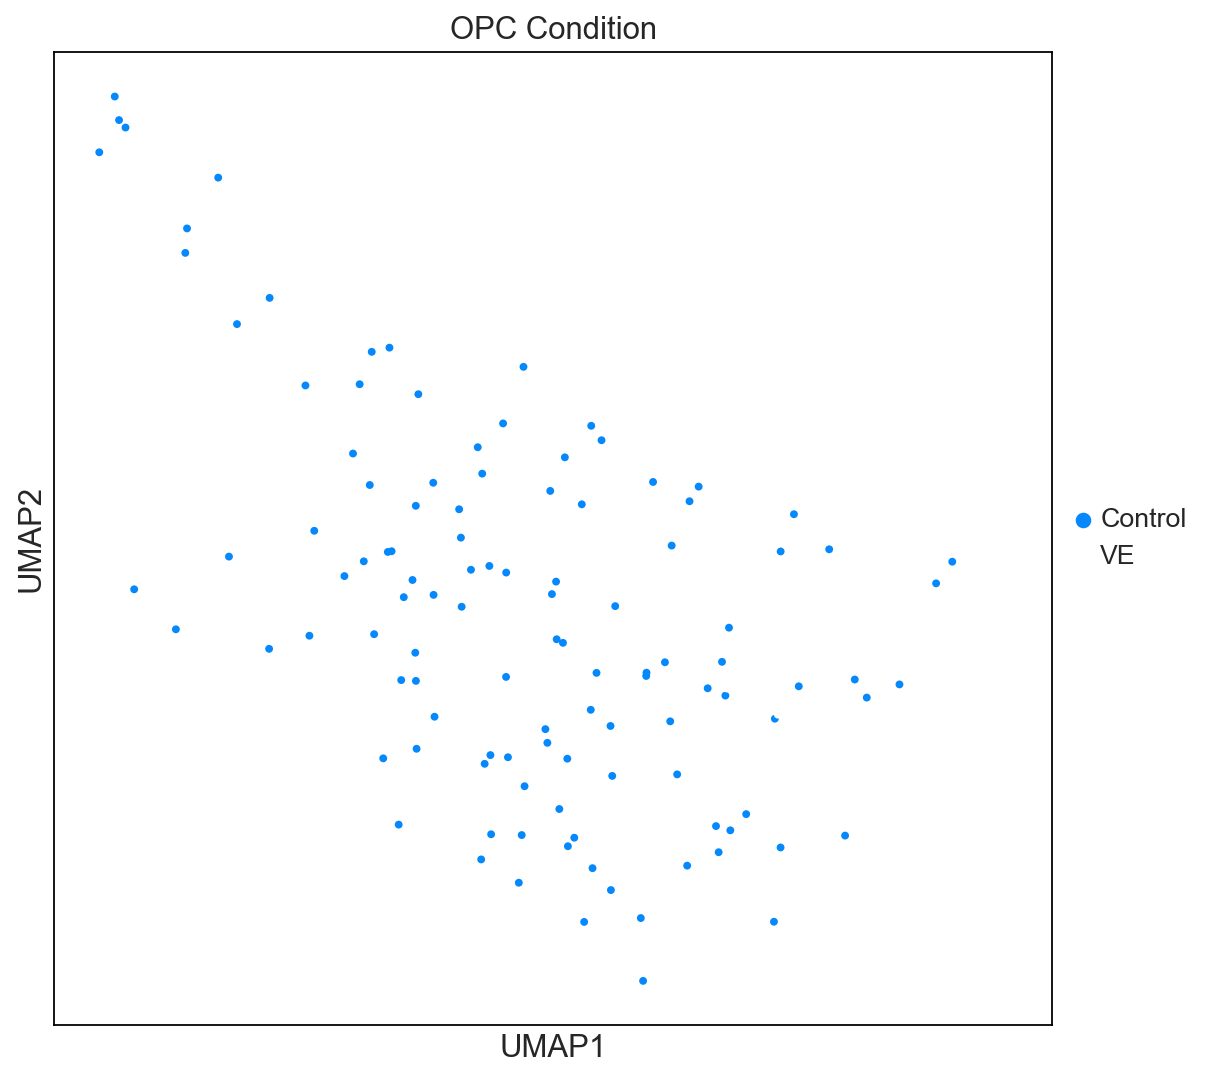

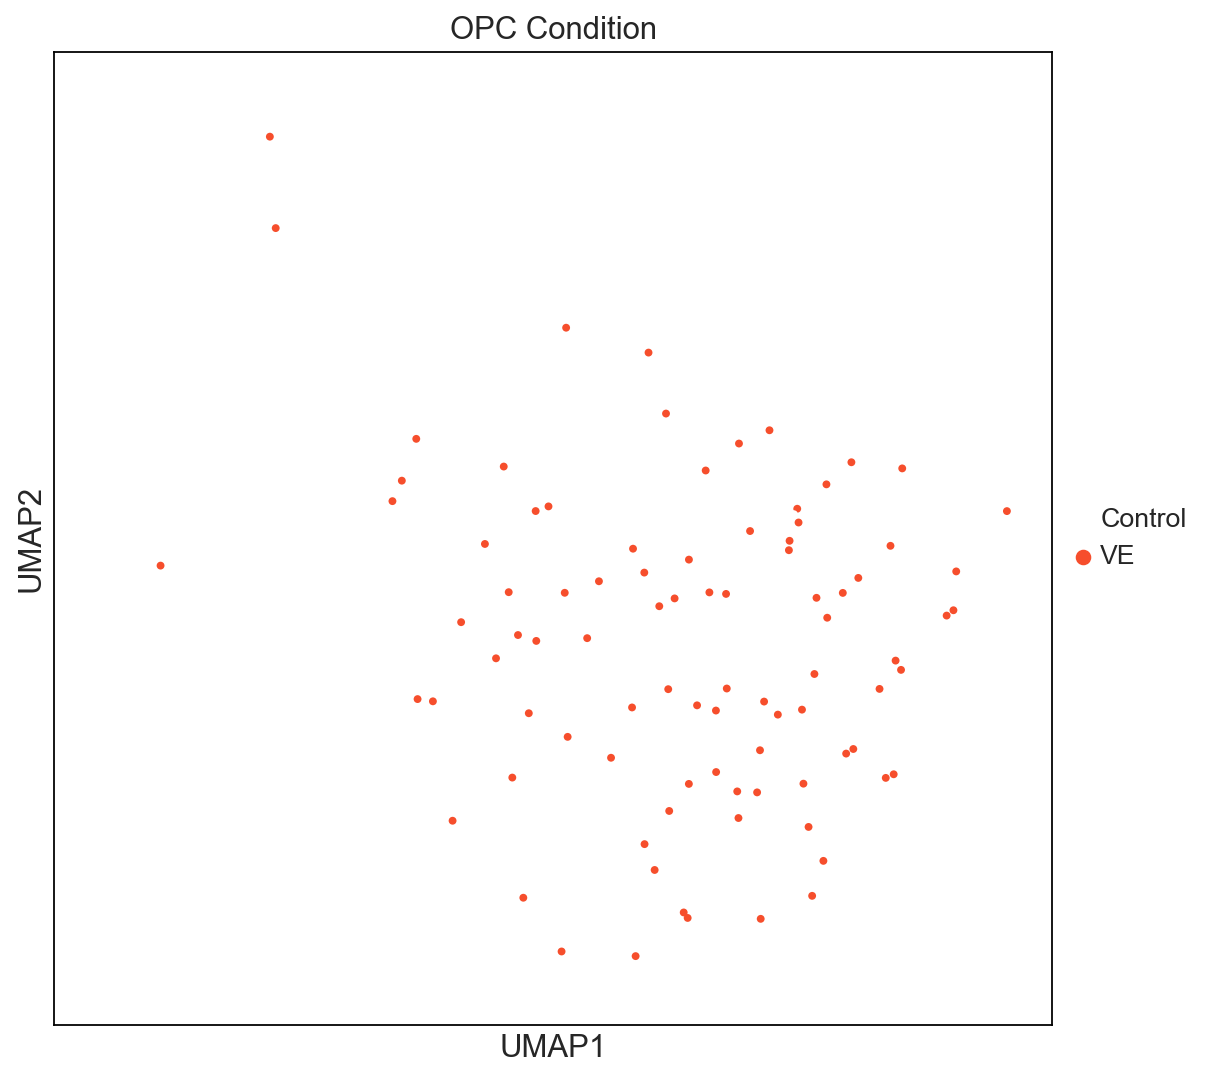

In [62]:
sc.pl.umap(adata_opc_cortex, 
           color= ['Condition'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=['#0488FC','#FFFFFFFF'],
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["OPC Condition"])


sc.pl.umap(adata_opc_cortex, 
           color= ['Condition'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=['#FFFFFFFF','#F64E2C'],
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["OPC Condition"])

### OPC Cortex control 

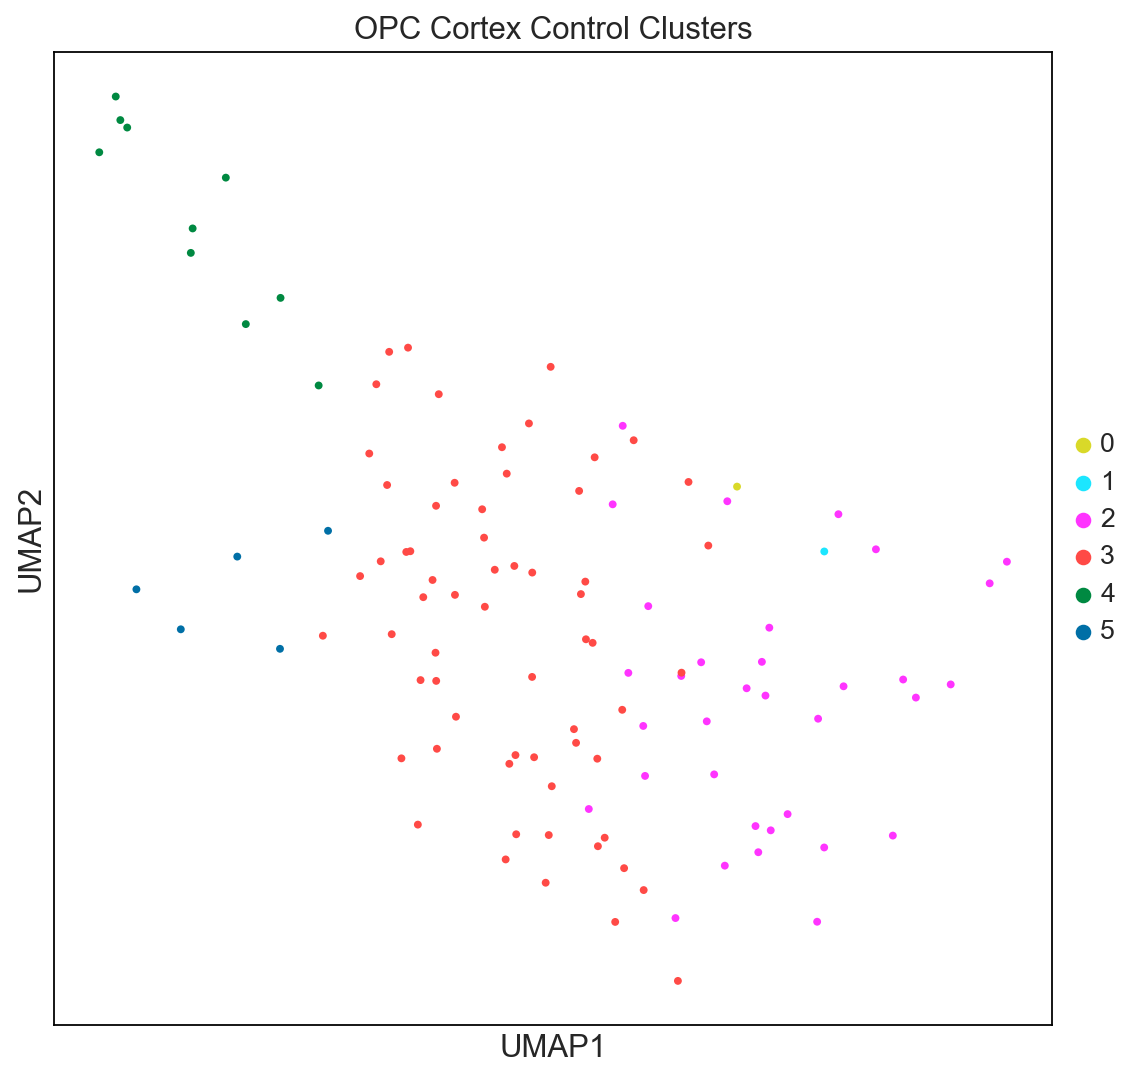

In [64]:
adata_opc_cortex_control = adata_opc_cortex[adata_opc_cortex.obs['Condition'].isin(['Control']),:].copy()

sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_opc_cortex_control, 
           color= ['PhenoGraph_clusters_opc'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=godsnot_64,
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["OPC Cortex Control Clusters"])

In [65]:
cell_counts_per_cluster_cortex_control = adata_opc_cortex_control.obs.PhenoGraph_clusters_opc.value_counts()
cell_counts_per_cluster_cortex_control = cell_counts_per_cluster_cortex_control.to_frame()
cell_counts_per_cluster_cortex_control

,PhenoGraph_clusters_opc
3,63
2,34
4,10
5,5
0,1
1,1


### Oligodendrocytes cortex VE

/Users/fragkogs/opt/anaconda3/envs/std/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


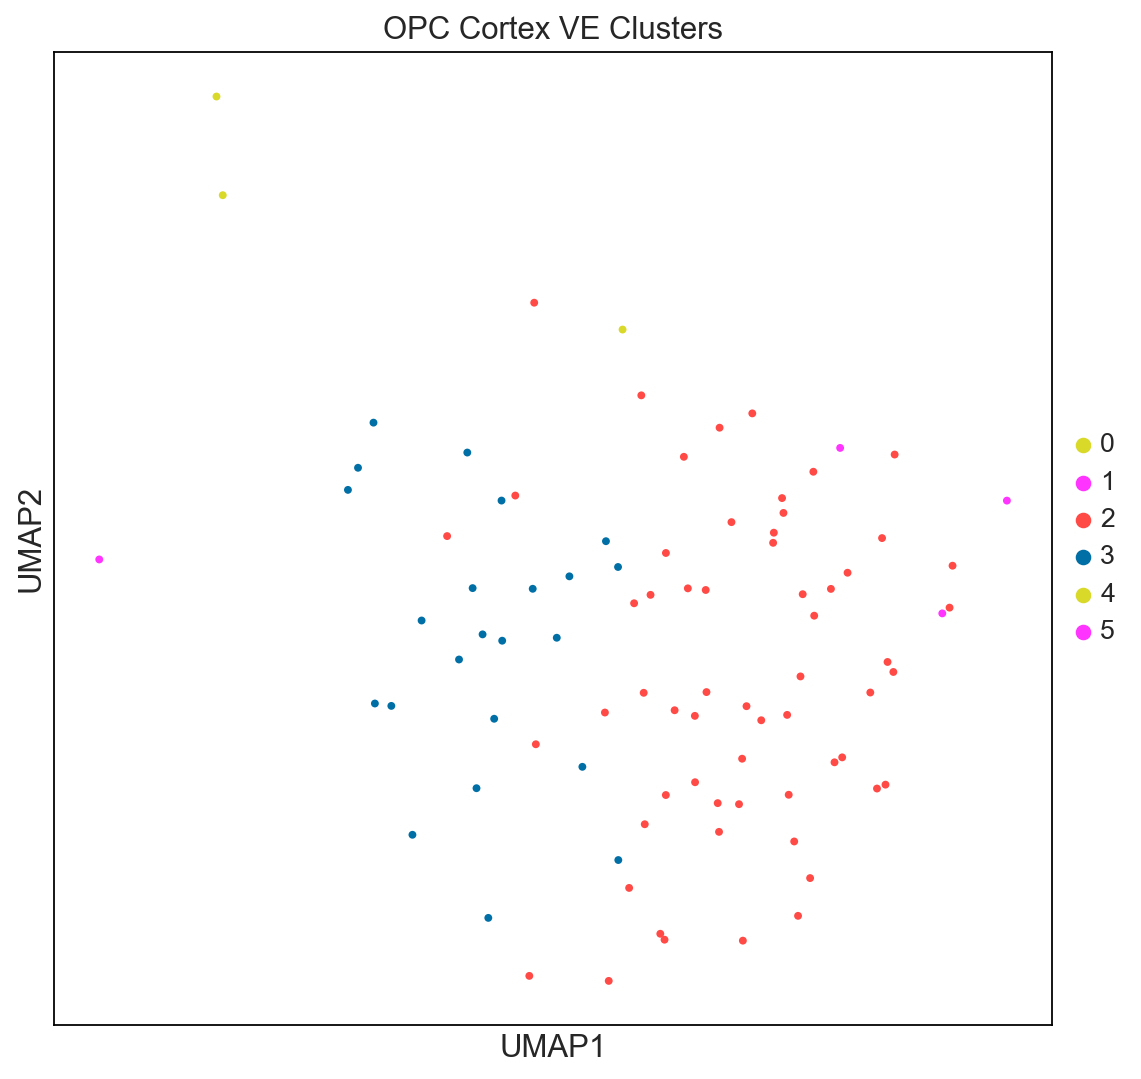

In [68]:
adata_opc_cortex_VE = adata_opc_cortex[adata_opc_cortex.obs['Condition'].isin(['VE']),:].copy()

sc.set_figure_params(figsize=(8, 8))
sc.pl.umap(adata_opc_cortex_VE, 
           color= ['PhenoGraph_clusters_opc'],
           ncols=2,
           edges = False,
           edges_width= 0.01,
           palette=["#d9d929", "#FF34FF", "#FF4A46", "#006FA6"],
           size=50, 
           #legend_loc='on data', 
           legend_fontsize=12,
           legend_fontoutline=2,
           title=["OPC Cortex VE Clusters"])

In [69]:
 cell_counts_per_cluster_cortex_VE = adata_opc_cortex_VE.obs.PhenoGraph_clusters_opc.value_counts()
cell_counts_per_cluster_cortex_VE = cell_counts_per_cluster_cortex_VE.to_frame()
cell_counts_per_cluster_cortex_VE

,PhenoGraph_clusters_opc
2,60
3,23
1,3
4,2
0,1
5,1


### Heatmaps of gene expression

In [ ]:
marker_genes_dict = dict()

marker_genes_dict = {'OPC-Cortex':[
]}



In [ ]:
adata_opc_cortex.layers['scaled'] = sc.pp.scale( adata_opc_cortex, copy=True).X
sc.pl.matrixplot( adata_opc_cortex, marker_genes_dict, groupby=['PhenoGraph_clusters_opc_str','Condition'], dendrogram=True,
                 colorbar_title='mean z-score', layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r',swap_axes=True)


sc.pl.dotplot( adata_opc_cortex, marker_genes_dict, groupby=['PhenoGraph_clusters_opc_str','Condition'], dendrogram=True,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

sc.pl.dotplot( adata_opc_cortex, marker_genes_dict, groupby=['PhenoGraph_clusters_opc_str','Condition'], dendrogram=False,
             colorbar_title='mean z-score', layer='scaled', vmin=-1, vmax=1, cmap='RdBu_r',swap_axes=True)

### Make a grouped bar plot of the number of cells per cluster per condition

**Brainstem**

In [71]:
# First merge the 2 data frames by indeces
mergedDF= cell_counts_per_cluster_BS_ctrl.merge(cell_counts_per_cluster_BS_VE, left_index=True, right_index=True, suffixes=('_Control', '_VE'),how = 'outer')
mergedDF.rename(columns = {'PhenoGraph_clusters_opc_Control' : 'Control', 'PhenoGraph_clusters_opc_VE' : 'VE'}, inplace = True)
mergedDF

,Control,VE
0,76,47
1,5,104
2,2,14
3,1,3
4,15,14
5,6,5


In [72]:
mergedDF = mergedDF.reset_index()
mergedDF = mergedDF.melt(id_vars=["index"])
mergedDF.rename(columns = {'index' : 'ClusterID', 'variable' : 'Condition', 'value' : 'N_cells'}, inplace = True)
mergedDF

,ClusterID,Condition,N_cells
0,0,Control,76
1,1,Control,5
2,2,Control,2
3,3,Control,1
4,4,Control,15
5,5,Control,6
6,0,VE,47
7,1,VE,104
8,2,VE,14
9,3,VE,3


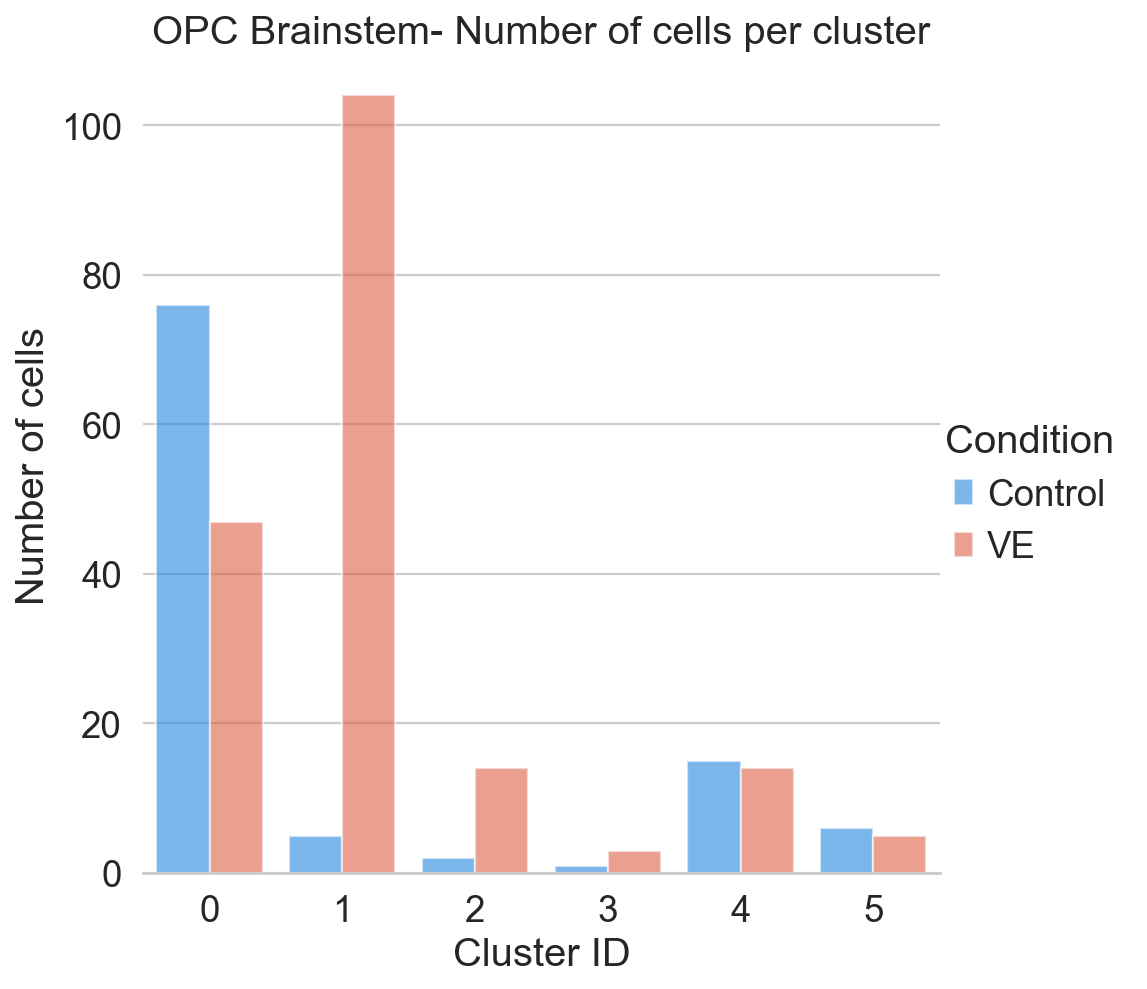

In [74]:
sns.set(font_scale=1.5, style = 'whitegrid') 
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=mergedDF, kind="bar",
    x="ClusterID", y="N_cells", hue="Condition",
    ci="sd", palette=['#0488FC','#F64E2C'], alpha=.6, height=6
)
g.despine(left=True)
g.set(title='OPC Brainstem- Number of cells per cluster')
g.set_axis_labels("Cluster ID", "Number of cells")

**Cortex**

In [75]:
# First merge the 2 data frames by indeces
mergedDF_2= cell_counts_per_cluster_cortex_control.merge(cell_counts_per_cluster_cortex_VE, left_index=True, right_index=True, suffixes=('_Control', '_VE'), how = 'outer')
mergedDF_2.rename(columns = {'PhenoGraph_clusters_opc_Control' : 'Control', 'PhenoGraph_clusters_opc_VE' : 'VE'}, inplace = True)
mergedDF_2

,Control,VE
0,1,1
1,1,3
2,34,60
3,63,23
4,10,2
5,5,1


In [76]:
mergedDF_2 = mergedDF_2.reset_index()
mergedDF_2 = mergedDF_2.melt(id_vars=["index"])
mergedDF_2.rename(columns = {'index' : 'ClusterID', 'variable' : 'Condition', 'value' : 'N_cells'}, inplace = True)
mergedDF_2

,ClusterID,Condition,N_cells
0,0,Control,1
1,1,Control,1
2,2,Control,34
3,3,Control,63
4,4,Control,10
5,5,Control,5
6,0,VE,1
7,1,VE,3
8,2,VE,60
9,3,VE,23


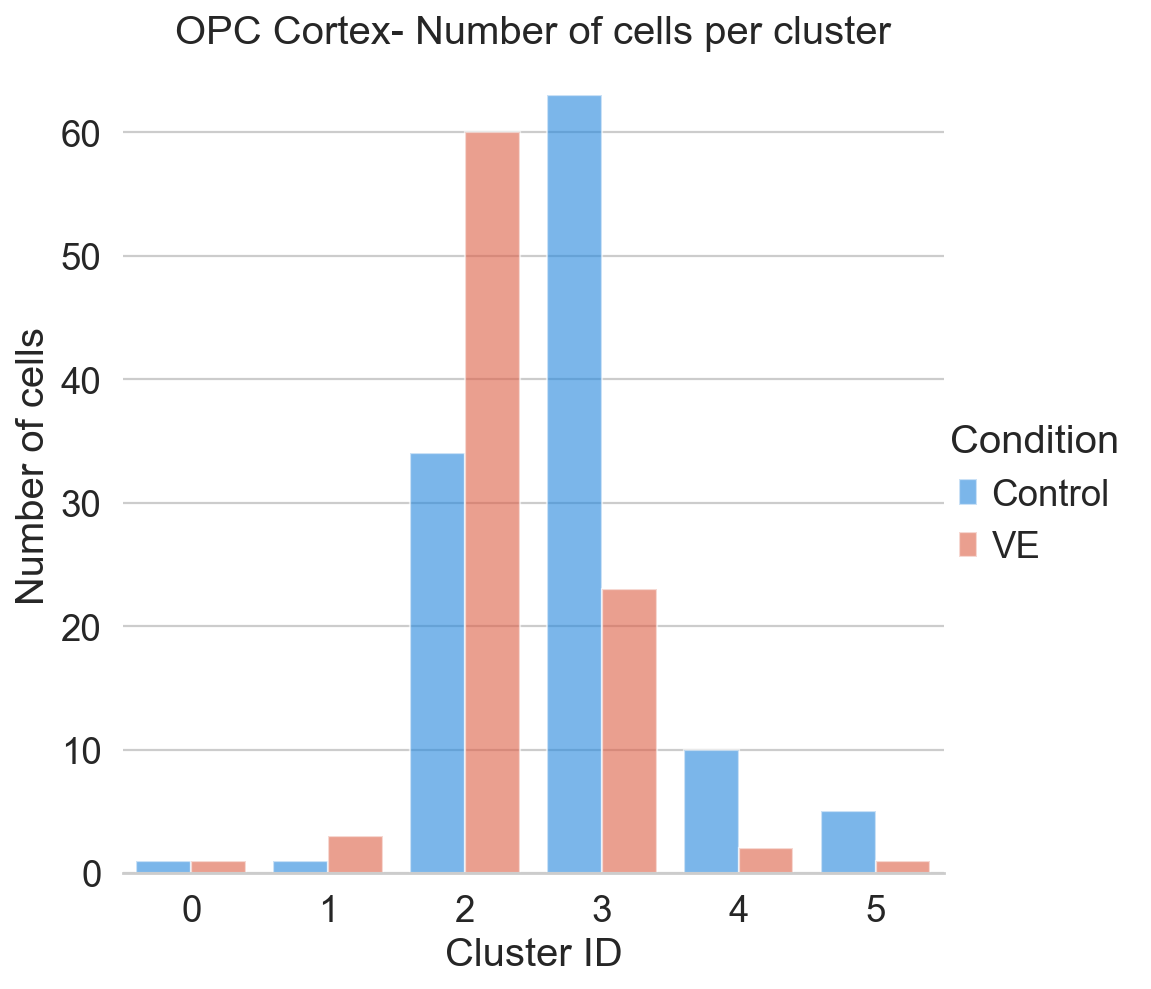

In [77]:
sns.set(font_scale=1.5, style = 'whitegrid') 
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=mergedDF_2, kind="bar",
    x="ClusterID", y="N_cells", hue="Condition",
    ci="sd", palette=['#0488FC','#F64E2C'], alpha=.6, height=6
)
g.despine(left=True)
g.set(title='OPC Cortex- Number of cells per cluster')
g.set_axis_labels("Cluster ID", "Number of cells")